In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
from glob import glob
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/Drive/')

Mounted at /content/Drive/


#**Importação e análise dos dados**

In [ ]:
core_idg = ImageDataGenerator(samplewise_center=False,
                              samplewise_std_normalization=False,
                              horizontal_flip=True,
                              vertical_flip=False,
                              height_shift_range=0.1,
                              width_shift_range=0.1,
                              #brightness_range=[0.7, 1.5],
                              rotation_range=30,
                              #shear_range=0.01,
                              fill_mode='nearest',
                              zoom_range=0.125,
                              #validation_split = 0.25,
                              rescale = 1./255
                              )

core_idg_test = ImageDataGenerator(samplewise_center=False,
                              samplewise_std_normalization=False,
                              horizontal_flip=False,
                              vertical_flip=False,
                              #height_shift_range=0.1,
                              #width_shift_range=0.1,
                              #brightness_range=[0.7, 1.5],
                              #rotation_range=3,
                              #shear_range=0.01,
                              fill_mode='nearest',
                              #zoom_range=0.125,
                              rescale = 1./255
                              )

In [ ]:
import pathlib

dataset_url_training = "/content/Drive/MyDrive/TCC/Base de dados/Skin Cancer/Amostra/Training"
dataset_url_test = "/content/Drive/MyDrive/TCC/Base de dados/Skin Cancer/Amostra/Test"
dataset_url_validation = "/content/Drive/MyDrive/TCC/Base de dados/Skin Cancer/Amostra/Validation"

data_dir_training = pathlib.Path(dataset_url_training)
data_dir_validation = pathlib.Path(dataset_url_validation)
data_dir_test = pathlib.Path(dataset_url_test)

image_count_training = len(list(data_dir_training.glob('*/*.jpg')))
image_count_validation = len(list(data_dir_validation.glob('*/*.jpg')))
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))

print(f'Quantidade de imagens na base de treinamento:', image_count_training)
print(f'Quantidade de imagens na base de validação:', image_count_validation)
print(f'Quantidade de imagens na base de teste:', image_count_test)

Quantidade de imagens na base de treinamento: 600
Quantidade de imagens na base de validação: 160
Quantidade de imagens na base de teste: 40


In [ ]:
img_height = 299
img_width = 299
batch_size = 32

In [ ]:
train_generator = core_idg.flow_from_directory(dataset_url_training,
                                               target_size = (img_height, img_width),
                                               batch_size = batch_size,
                                               save_format='jpg',
                                               class_mode = 'sparse'
                                               )

train_generator.class_indices

Found 600 images belonging to 4 classes.


{'bcc': 0, 'bkl': 1, 'mel': 2, 'nv': 3}

In [ ]:
val_generator = core_idg.flow_from_directory(dataset_url_validation,
                                             target_size = (img_height, img_width),
                                             batch_size = batch_size,
                                             save_format='jpg',
                                             class_mode = 'sparse')

val_generator.class_indices

Found 160 images belonging to 4 classes.


{'bcc': 0, 'bkl': 1, 'mel': 2, 'nv': 3}

In [ ]:
test_generator = core_idg_test.flow_from_directory(dataset_url_test,
                                             target_size = (img_height, img_width),
                                             batch_size = batch_size,
                                             save_format='jpg',
                                             class_mode = 'sparse'
                                             )

test_generator.class_indices

Found 40 images belonging to 4 classes.


{'bcc': 0, 'bkl': 1, 'mel': 2, 'nv': 3}

#**Modelo 5**

##*Treinamento*

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler

num_classes = 4

pretrained_base = tf.keras.applications.inception_v3.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(img_height, img_width, 3),
    pooling='max',
    classes=num_classes,
    classifier_activation='softmax'
)

pretrained_base.Trainable = False

model_5 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  pretrained_base,
  tf.keras.layers.Flatten(),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(rate=0.3),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

early_stopping = EarlyStopping(
    min_delta = 0.00001,
    monitor = 'val_loss',
    patience=16,
    restore_best_weights=True,
    mode = 'min'
)

path_check_point_model_5 = "/content/Drive/MyDrive/TCC/Modelos/Modelos treinados/Modelo 5/Checkpoint_model5_4396.hdf5"

check_point = ModelCheckpoint(
    path_check_point_model_5,
    monitor = 'val_loss',
    verbose = 1,
    save_best_only=True,
    save_weights_only=False,
    mode='min'
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor = 0.7,
                              patience = 5,
                              min_lr=0.0001)

model_5.compile(
  optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=0.007),
  loss = 'sparse_categorical_crossentropy',
  metrics=['accuracy']
)

87910968/87910968 [==============================] - 4s 0us/step


In [ ]:
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = val_generator.n // val_generator.batch_size

epochs = 600

history = model_5.fit(
  train_generator,
  steps_per_epoch = STEP_SIZE_TRAIN, #isso possivelmente não faz sentido
  validation_data = val_generator,
  validation_steps = STEP_SIZE_VALID, #não faz sentido, pois os dados de validação não são do formato tf.data.Dataset
  epochs=epochs,
  callbacks=[early_stopping, check_point, reduce_lr],
  workers = 3
)

Epoch 1/600
28/28 [==============================] - ETA: 0s - loss: 1.7155 - accuracy: 0.3122
Epoch 1: val_loss improved from inf to 2.77580, saving model to /content/Drive/MyDrive/TCC/Modelos/Modelos treinados/Modelo 5/Checkpoint_model5_1200.hdf5
28/28 [==============================] - 246s 8s/step - loss: 1.7155 - accuracy: 0.3122 - val_loss: 2.7758 - val_accuracy: 0.2411 - lr: 0.0070
Epoch 2/600
28/28 [==============================] - ETA: 0s - loss: 1.4969 - accuracy: 0.4090
Epoch 2: val_loss did not improve from 2.77580
28/28 [==============================] - 26s 910ms/step - loss: 1.4969 - accuracy: 0.4090 - val_loss: 3.9686 - val_accuracy: 0.2545 - lr: 0.0070
Epoch 3/600
28/28 [==============================] - ETA: 0s - loss: 1.5116 - accuracy: 0.3836
Epoch 3: val_loss improved from 2.77580 to 1.57360, saving model to /content/Drive/MyDrive/TCC/Modelos/Modelos treinados/Modelo 5/Checkpoint_model5_1200.hdf5
28/28 [==============================] - 29s 994ms/step - loss: 1.51

##*Teste - 4396 imagens*

Teste com um total de 4396 imagens, sendo, 3296 para treinamento, 880 para validação e 220 para teste. As transformações realizadas nas imagens pertecentes à base de treinamento são:

```
horizontal_flip=True,
vertical_flip=False,
height_shift_range=0.1,
width_shift_range=0.1,
rotation_range=30,
zoom_range=0.125,
```

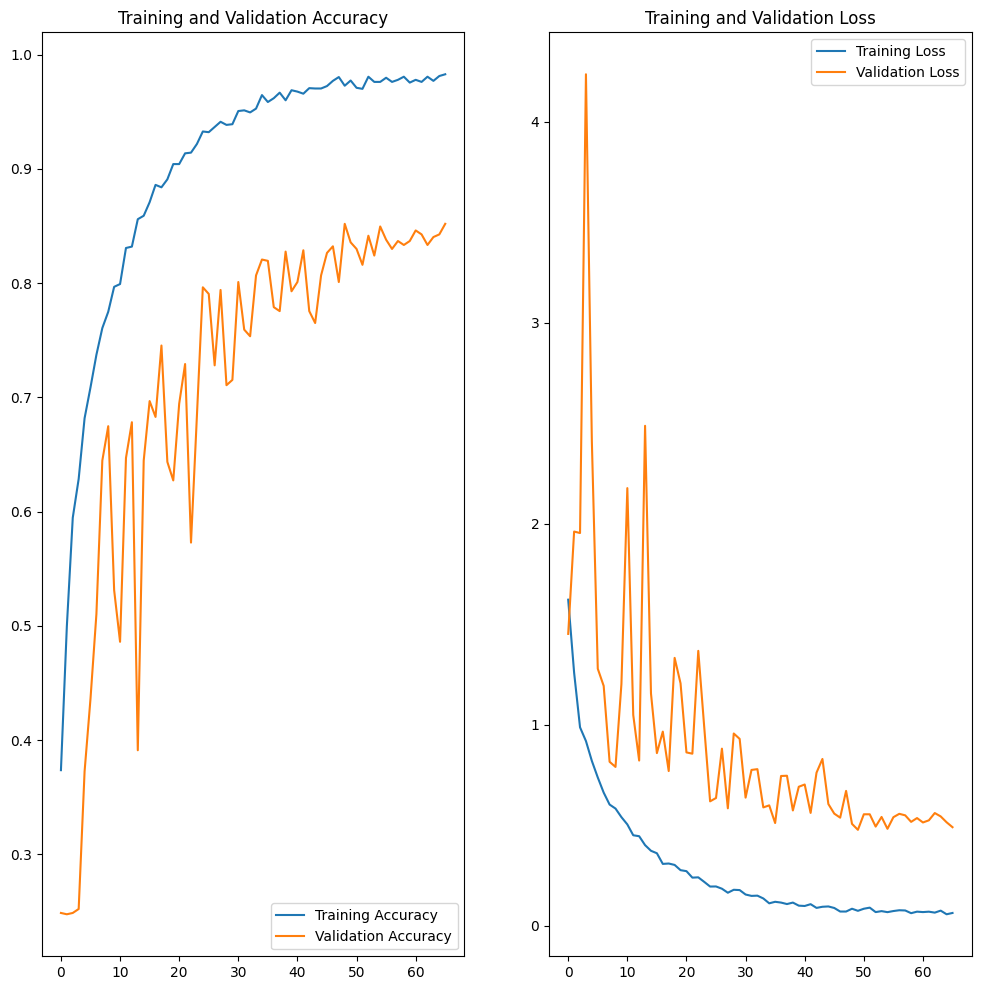

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(66)

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from keras.utils import load_img, img_to_array

#DataFrame de treinamento
image_path_training_bcc = list(data_dir_training.glob('bcc/*.jpg'))
df_bcc = pd.DataFrame(image_path_training_bcc, columns=['images'])
df_bcc['classes']='bcc'

image_path_training_bkl = list(data_dir_training.glob('bkl/*.jpg'))
df_bkl = pd.DataFrame(image_path_training_bkl, columns=['images'])
df_bkl['classes']='bkl'

image_path_training_mel = list(data_dir_training.glob('mel/*.jpg'))
df_mel = pd.DataFrame(image_path_training_mel, columns=['images'])
df_mel['classes']='mel'

image_path_training_nv = list(data_dir_training.glob('nv/*.jpg'))
df_nv = pd.DataFrame(image_path_training_nv, columns=['images'])
df_nv['classes']='nv'

df_training = pd.concat([df_bcc, df_bkl, df_mel, df_nv], ignore_index=True)
df_training['Tipo'] = 'Training'

# DataFrame de validação
image_path_validation_bcc = list(data_dir_validation.glob('bcc/*.jpg'))
df_bcc = pd.DataFrame(image_path_validation_bcc, columns=['images'])
df_bcc['classes']='bcc'

image_path_validation_bkl = list(data_dir_validation.glob('bkl/*.jpg'))
df_bkl = pd.DataFrame(image_path_validation_bkl, columns=['images'])
df_bkl['classes']='bkl'

image_path_validation_mel = list(data_dir_validation.glob('mel/*.jpg'))
df_mel = pd.DataFrame(image_path_validation_mel, columns=['images'])
df_mel['classes']='mel'

image_path_validation_nv = list(data_dir_validation.glob('nv/*.jpg'))
df_nv = pd.DataFrame(image_path_validation_nv, columns=['images'])
df_nv['classes']='nv'

df_validation = pd.concat([df_bcc, df_bkl, df_mel, df_nv], ignore_index=True)
df_validation['Tipo'] = 'Validation'

#DataFrame de teste
image_path_test_bcc = list(data_dir_test.glob('bcc/*.jpg'))
df_bcc = pd.DataFrame(image_path_test_bcc, columns=['images'])
df_bcc['classes']='bcc'

image_path_test_bkl = list(data_dir_test.glob('bkl/*.jpg'))
df_bkl = pd.DataFrame(image_path_test_bkl, columns=['images'])
df_bkl['classes']='bkl'

image_path_test_mel = list(data_dir_test.glob('mel/*.jpg'))
df_mel = pd.DataFrame(image_path_test_mel, columns=['images'])
df_mel['classes']='mel'

image_path_test_nv = list(data_dir_test.glob('nv/*.jpg'))
df_nv = pd.DataFrame(image_path_test_nv, columns=['images'])
df_nv['classes']='nv'

df_teste = pd.concat([df_bcc, df_bkl, df_mel, df_nv], ignore_index=True)
df_teste['Tipo'] = 'Test'

#DataFrame final
df_final = pd.concat([df_training, df_validation, df_teste], ignore_index=True)

imgs = []
for image_name in df_teste['images'].values:
   img = load_img(image_name, target_size = (img_height, img_width), color_mode = 'rgb')
   img_array = img_to_array(img)
   img_array = img_array/255.
   imgs.append(img_array)
imgs = np.array(imgs)

In [ ]:
path_check_point_model_5 = "/content/Drive/MyDrive/TCC/Modelos/Modelos treinados/Modelo 5/Checkpoint_model5_4396_v3.hdf5"
#Carregando o melhor conjunto de pesos
model_test_5 = tf.keras.models.load_model(path_check_point_model_5)

#Realizando a predição no modelo treinado
y_predict = model_test_5.predict(imgs, verbose=1)
class_pred = []

for pred in y_predict:
  class_number = np.argmax(pred)
  if class_number == 0:
    class_pred.append('bcc')
  elif class_number == 1:
    class_pred.append('bkl')
  elif class_number == 2:
    class_pred.append('mel')
  else:
    class_pred.append('nv')

y_true = df_teste['classes'].values

7/7 [==============================] - 29s 4s/step


In [ ]:
model_test_5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, None, None, None)  0         
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization_94 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

erro, acurácia = model_test_5.evaluate(test_generator, batch_size = batch_size)
print(classification_report(y_true, class_pred, target_names = ['bcc','bkl','mel','nv']))
print('\n')
print('Erro:', format(erro, '.2f'), '\nAcurácia:', format(acurácia, '.2f'))

7/7 [==============================] - 4s 387ms/step - loss: 0.4720 - accuracy: 0.8455
              precision    recall  f1-score   support

         bcc       0.98      0.95      0.96        55
         bkl       0.79      0.82      0.80        55
         mel       0.76      0.82      0.79        55
          nv       0.86      0.80      0.83        55

    accuracy                           0.85       220
   macro avg       0.85      0.85      0.85       220
weighted avg       0.85      0.85      0.85       220



Erro: 0.47 
Acurácia: 0.85


In [ ]:
pred_aux = class_pred.copy()

for i in list(range(0, 55, 1)):
  if pred_aux[i] != 'bcc':
    pred_aux[i] = 'non_bcc'

for i in list(range(55, 110, 1)):
  if pred_aux[i] != 'bkl':
    pred_aux[i] = 'non_bkl'

for i in list(range(110, 165, 1)):
  if pred_aux[i] != 'mel':
    pred_aux[i] = 'non_mel'

for i in list(range(165, 220, 1)):
  if pred_aux[i] != 'nv':
    pred_aux[i] = 'non_nv'

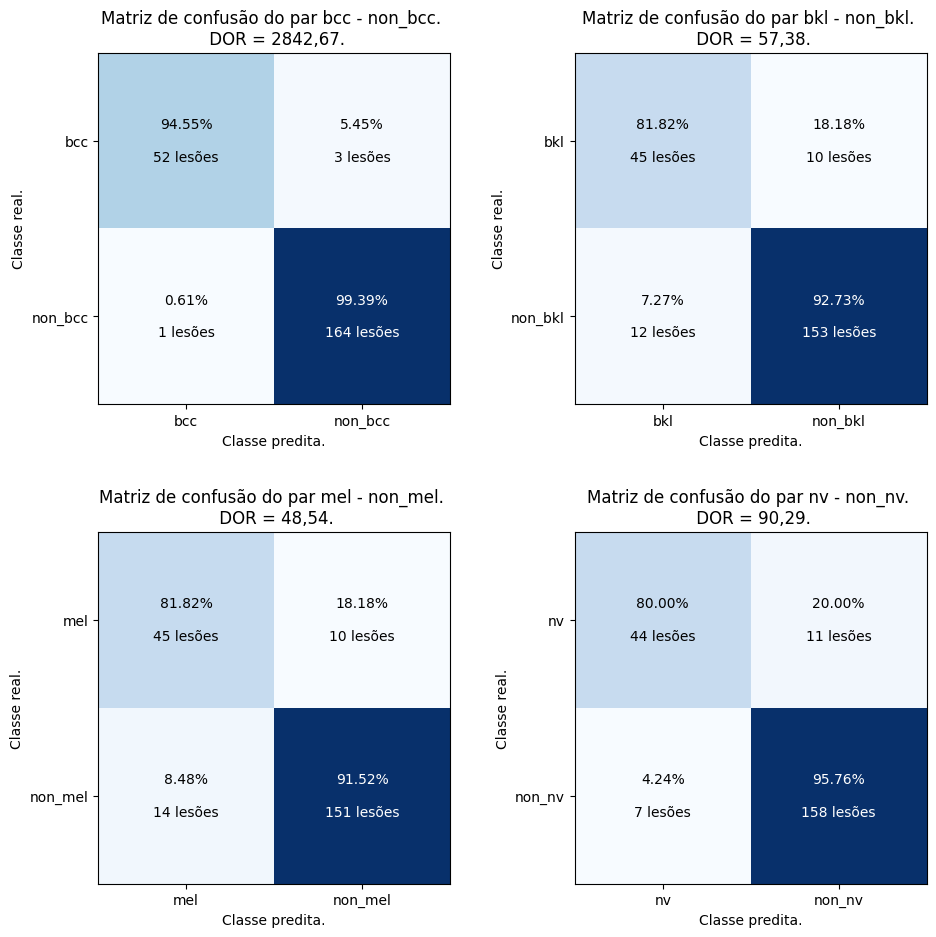

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

classes_pair = [['bcc','non_bcc'], ['bkl','non_bkl'], ['mel','non_mel'], ['nv', 'non_nv']]
cm = []
dor = []

for i in range(len(classes_pair)):
  aux_true = []
  aux_pred = []

  aux_true = [x if x == classes_pair[i][0] else classes_pair[i][1] for x in y_true]
  aux_pred = [y if y == classes_pair[i][0] else classes_pair[i][1] for y in class_pred]

  cm_aux = confusion_matrix(aux_true, aux_pred, normalize=None , labels=classes_pair[i])
  cm.append(cm_aux)

  if cm_aux[0,1] == 0 or cm_aux[1,0] == 0 or cm_aux[0,1] == 0:
    dor.append('Não se define')
  else:
    dor_aux = round((cm_aux[0,0]/cm_aux[0,1])/(cm_aux[1,0]/cm_aux[1,1]), 2)
    dor.append(dor_aux)

dor = [str(i) for i in dor]
dor = [i.replace('.',',') for i in dor]


plt.figure(figsize = (10, 10))

for i in range(len(classes_pair)):
  ax=plt.subplot(2, 2, i+1)
  title=f'Matriz de confusão do par {classes_pair[i][0]} - {classes_pair[i][1]}. \n DOR = {dor[i]}.'
  plt.imshow(cm[i], interpolation='nearest', cmap=plt.cm.Blues)
  plt.title(title)
  tick_marks = np.arange(len(classes_pair[i]))
  plt.xticks(tick_marks, classes_pair[i], rotation=0)
  plt.yticks(tick_marks, classes_pair[i])
  thresh = cm[i].max() / 2.
  for k, p in itertools.product(range(cm[i].shape[0]), range(cm[i].shape[1])):
    if k == 0:
        plt.text(p, k, format(cm[i][k, p]*100/55, '.2f')+'%\n\n'+format(cm[i][k, p], '.0f') + ' lesões',
        horizontalalignment="center",
        verticalalignment="center",
        color="white" if cm[i][k, p] > thresh else "black",
        )
    else:
        plt.text(p, k, format(cm[i][k, p]*100/165, '.2f')+'%\n\n'+format(cm[i][k, p], '.0f') + ' lesões',
        horizontalalignment="center",
        verticalalignment="center",
        color="white" if cm[i][k, p] > thresh else "black",
        )

    plt.ylabel('Classe real.')
    plt.xlabel('Classe predita.')
    plt.tight_layout(pad = 3)

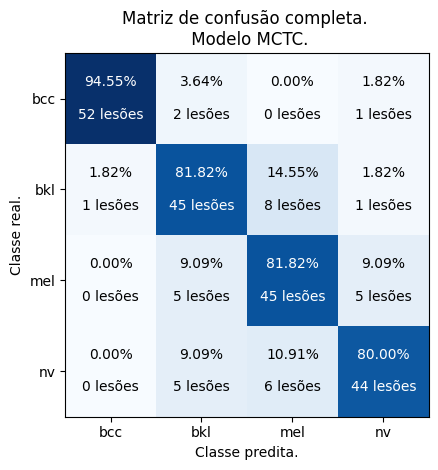

In [ ]:
import itertools

#Plotando a matriz de confusão
class_names=['bcc','bkl','mel','nv']
cm=confusion_matrix(y_true, class_pred, normalize='true')
title='Matriz de confusão completa. \n Modelo MCTC.'
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks, class_names)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, format(cm[i, j]*100, '.2f')+'%\n\n'+format(cm[i, j]*55, '.0f') + ' lesões',
  horizontalalignment="center",
  verticalalignment="center",
  color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Classe real.')
plt.xlabel('Classe predita.')
plt.tight_layout()

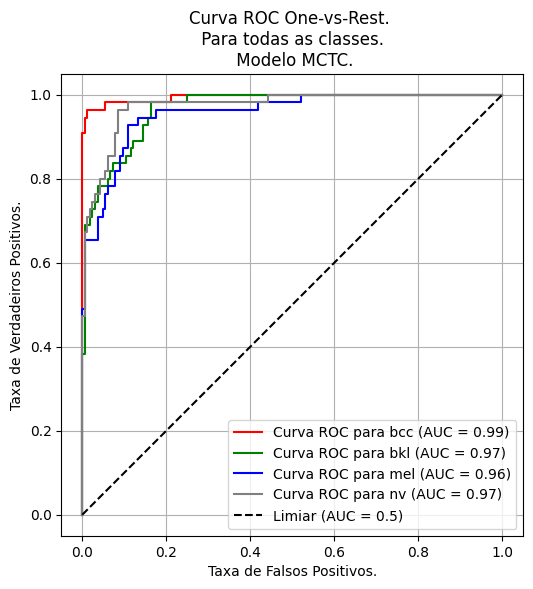

In [ ]:
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))

class_pred_bin = LabelBinarizer().fit(y_true)
y_true_bin = class_pred_bin.transform(y_true)

colors = cycle(["red","green","blue","gray"])
classes = class_pred_bin.classes_
n_classes = len(np.unique(classes))
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(y_true_bin[:, class_id],
                                     y_predict[:, class_id],
                                     name=f"Curva ROC para {classes[class_id]}",
                                     color=color,
                                     ax=ax
                                     )

plt.plot([0, 1], [0, 1], "k--", label="Limiar (AUC = 0.5)")
plt.axis("square")
plt.xlabel("Taxa de Falsos Positivos.")
plt.ylabel("Taxa de Verdadeiros Positivos.")
plt.title("Curva ROC One-vs-Rest. \n Para todas as classes. \n Modelo MCTC.")
plt.legend()
plt.grid()
plt.show()

In [ ]:
df_final.to_excel('/content/Drive/MyDrive/TCC/Base de dados/Skin Cancer/Melhor desempenho/Imagens com melhor resultado_v3_.xlsx', sheet_name='Imagens com melhor resultado_v3')

In [ ]:
resultados = [acc, val_acc]
df_1 = pd.Series(acc)
df_2 = pd.Series(val_acc)
df_3 = pd.Series(loss)
df_4 = pd.Series(val_loss)

df_1.to_excel('/content/Drive/MyDrive/TCC/Base de dados/Skin Cancer/Melhor desempenho/Acurácia.xlsx', sheet_name='Acurácia')
df_2.to_excel('/content/Drive/MyDrive/TCC/Base de dados/Skin Cancer/Melhor desempenho/Acurácia_validação.xlsx', sheet_name='Acurácia_validação')
df_3.to_excel('/content/Drive/MyDrive/TCC/Base de dados/Skin Cancer/Melhor desempenho/Erro.xlsx', sheet_name='Erro')
df_4.to_excel('/content/Drive/MyDrive/TCC/Base de dados/Skin Cancer/Melhor desempenho/Erro_validação.xlsx', sheet_name='Erro_validação')

##*Teste - 4000 imagens*

Teste com um total de 4000 imagens, sendo, 3000 para treinamento, 800 para validação e 200 para teste. As transformações realizadas nas imagens pertecentes à base de treinamento são:

```
horizontal_flip=True,
vertical_flip=False,
height_shift_range=0.1,
width_shift_range=0.1,
rotation_range=30,
zoom_range=0.125,
```

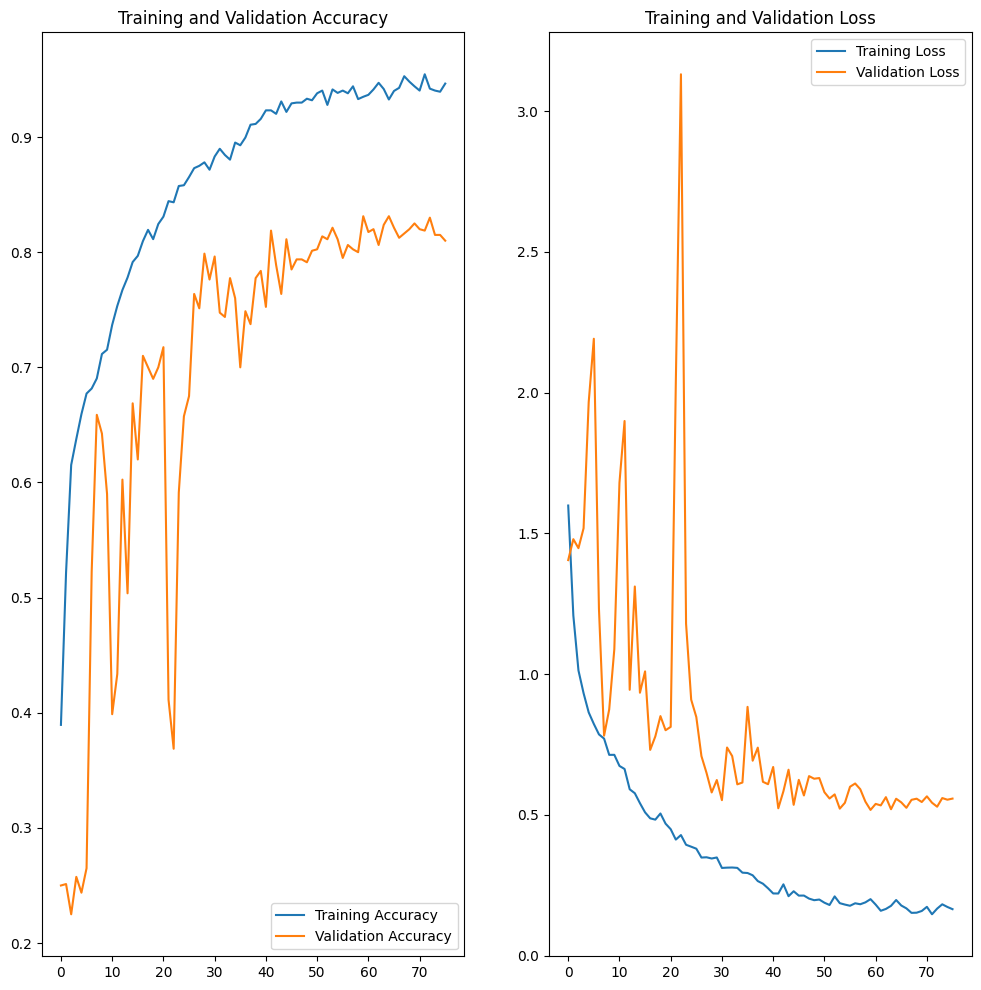

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(76)

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from keras.utils import load_img, img_to_array

image_path_test_bcc = list(data_dir_test.glob('bcc/*.jpg'))
df_bcc = pd.DataFrame(image_path_test_bcc, columns=['images'])
df_bcc['classes']='bcc'

image_path_test_bkl = list(data_dir_test.glob('bkl/*.jpg'))
df_bkl = pd.DataFrame(image_path_test_bkl, columns=['images'])
df_bkl['classes']='bkl'

image_path_test_mel = list(data_dir_test.glob('mel/*.jpg'))
df_mel = pd.DataFrame(image_path_test_mel, columns=['images'])
df_mel['classes']='mel'

image_path_test_nv = list(data_dir_test.glob('nv/*.jpg'))
df_nv = pd.DataFrame(image_path_test_nv, columns=['images'])
df_nv['classes']='nv'

df_teste = pd.concat([df_bcc, df_bkl, df_mel, df_nv], ignore_index=True)

imgs = []
for image_name in df_teste['images'].values:
   img = load_img(image_name, target_size = (img_height, img_width), color_mode = 'rgb')
   img_array = img_to_array(img)
   img_array = img_array/255.
   imgs.append(img_array)
imgs = np.array(imgs)

In [ ]:
path_check_point_model_5 = "/content/Drive/MyDrive/TCC/Modelos/Modelos treinados/Modelo 5/Checkpoint_model5_4000.hdf5"
#Carregando o melhor conjunto de pesos
model_test_5 = tf.keras.models.load_model(path_check_point_model_5)

#Realizando a predição no modelo treinado
y_predict = model_test_5.predict(imgs, verbose=1)
class_pred = []

for pred in y_predict:
  class_number = np.argmax(pred)
  if class_number == 0:
    class_pred.append('bcc')
  elif class_number == 1:
    class_pred.append('bkl')
  elif class_number == 2:
    class_pred.append('mel')
  else:
    class_pred.append('nv')

y_true = df_teste['classes'].values

7/7 [==============================] - 13s 335ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

erro, acurácia = model_test_5.evaluate(test_generator, batch_size = batch_size)
print(classification_report(y_true, class_pred, target_names = ['bcc','bkl','mel','nv']))
print('\n')
print('Erro:', format(erro, '.2f'), '\nAcurácia:', format(acurácia, '.2f'))

7/7 [==============================] - 4s 328ms/step - loss: 0.5616 - accuracy: 0.8350
              precision    recall  f1-score   support

         bcc       0.98      0.94      0.96        50
         bkl       0.76      0.88      0.81        50
         mel       0.78      0.72      0.75        50
          nv       0.83      0.80      0.82        50

    accuracy                           0.83       200
   macro avg       0.84      0.83      0.84       200
weighted avg       0.84      0.83      0.84       200



Erro: 0.56 
Acurácia: 0.83


In [ ]:
pred_aux = class_pred.copy()

for i in list(range(0, 50, 1)):
  if pred_aux[i] != 'bcc':
    pred_aux[i] = 'non_bcc'

for i in list(range(50, 100, 1)):
  if pred_aux[i] != 'bkl':
    pred_aux[i] = 'non_bkl'

for i in list(range(100, 150, 1)):
  if pred_aux[i] != 'mel':
    pred_aux[i] = 'non_mel'

for i in list(range(150, 200, 1)):
  if pred_aux[i] != 'nv':
    pred_aux[i] = 'non_nv'

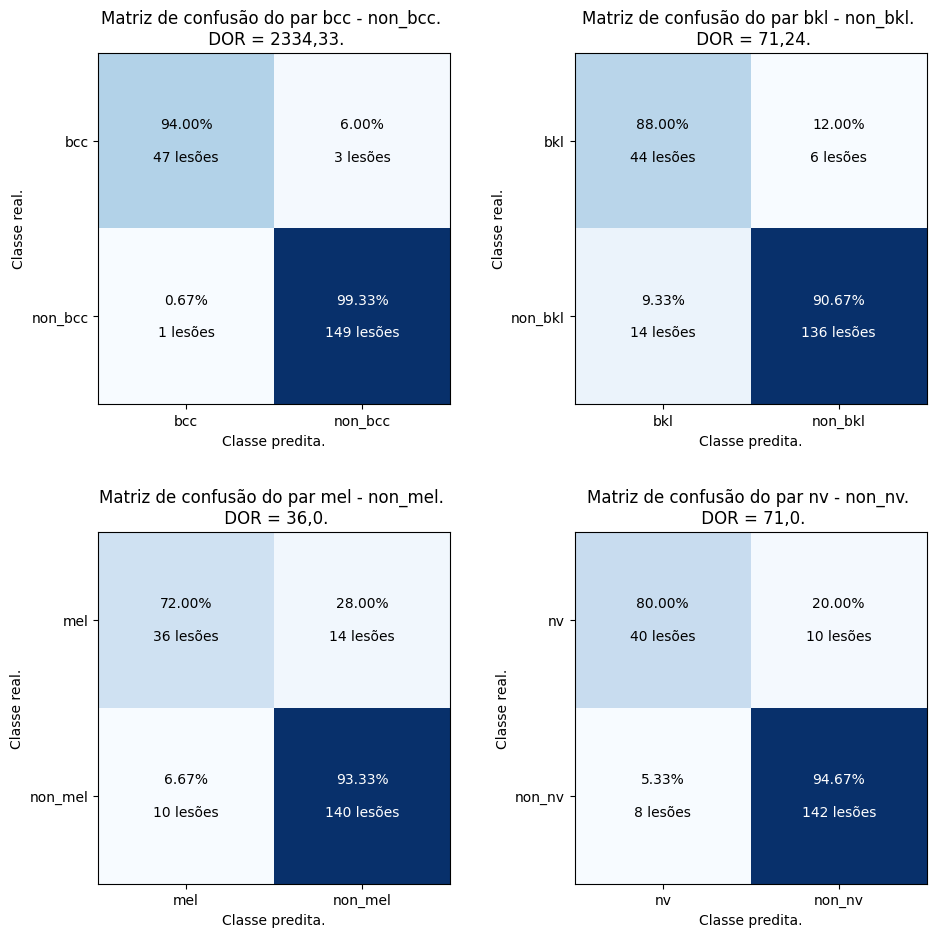

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

classes_pair = [['bcc','non_bcc'], ['bkl','non_bkl'], ['mel','non_mel'], ['nv', 'non_nv']]
cm = []
dor = []

for i in range(len(classes_pair)):
  aux_true = []
  aux_pred = []

  aux_true = [x if x == classes_pair[i][0] else classes_pair[i][1] for x in y_true]
  aux_pred = [y if y == classes_pair[i][0] else classes_pair[i][1] for y in class_pred]

  cm_aux = confusion_matrix(aux_true, aux_pred, normalize=None , labels=classes_pair[i])
  cm.append(cm_aux)

  if cm_aux[0,1] == 0 or cm_aux[1,0] == 0 or cm_aux[0,1] == 0:
    dor.append('Não se define')
  else:
    dor_aux = round((cm_aux[0,0]/cm_aux[0,1])/(cm_aux[1,0]/cm_aux[1,1]), 2)
    dor.append(dor_aux)

dor = [str(i) for i in dor]
dor = [i.replace('.',',') for i in dor]


plt.figure(figsize = (10, 10))

for i in range(len(classes_pair)):
  ax=plt.subplot(2, 2, i+1)
  title=f'Matriz de confusão do par {classes_pair[i][0]} - {classes_pair[i][1]}. \n DOR = {dor[i]}.'
  plt.imshow(cm[i], interpolation='nearest', cmap=plt.cm.Blues)
  plt.title(title)
  tick_marks = np.arange(len(classes_pair[i]))
  plt.xticks(tick_marks, classes_pair[i], rotation=0)
  plt.yticks(tick_marks, classes_pair[i])
  thresh = cm[i].max() / 2.
  for k, p in itertools.product(range(cm[i].shape[0]), range(cm[i].shape[1])):
    if k == 0:
        plt.text(p, k, format(cm[i][k, p]*100/50, '.2f')+'%\n\n'+format(cm[i][k, p], '.0f') + ' lesões',
        horizontalalignment="center",
        verticalalignment="center",
        color="white" if cm[i][k, p] > thresh else "black",
        )
    else:
        plt.text(p, k, format(cm[i][k, p]*100/150, '.2f')+'%\n\n'+format(cm[i][k, p], '.0f') + ' lesões',
        horizontalalignment="center",
        verticalalignment="center",
        color="white" if cm[i][k, p] > thresh else "black",
        )

    plt.ylabel('Classe real.')
    plt.xlabel('Classe predita.')
    plt.tight_layout(pad = 3)

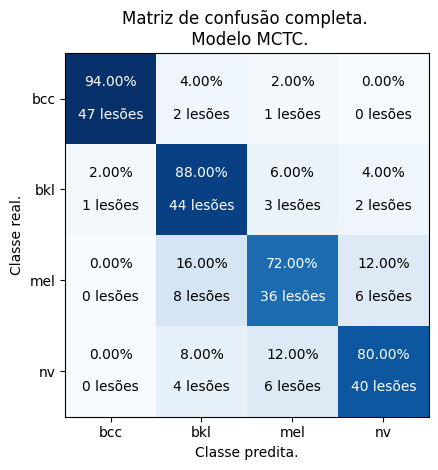

In [ ]:
import itertools

#Plotando a matriz de confusão
class_names=['bcc','bkl','mel','nv']
cm=confusion_matrix(y_true, class_pred, normalize='true')
title='Matriz de confusão completa. \n Modelo MCTC.'
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks, class_names)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, format(cm[i, j]*100, '.2f')+'%\n\n'+format(cm[i, j]*50, '.0f') + ' lesões',
  horizontalalignment="center",
  verticalalignment="center",
  color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Classe real.')
plt.xlabel('Classe predita.')
plt.tight_layout()

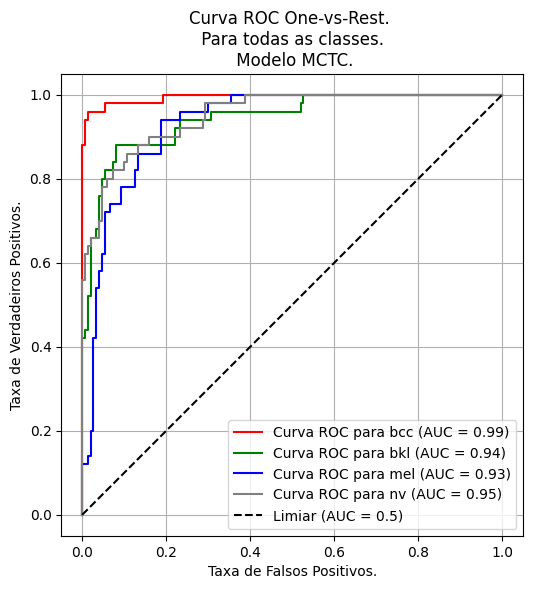

In [ ]:
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))

class_pred_bin = LabelBinarizer().fit(y_true)
y_true_bin = class_pred_bin.transform(y_true)

colors = cycle(["red","green","blue","gray"])
classes = class_pred_bin.classes_
n_classes = len(np.unique(classes))
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(y_true_bin[:, class_id],
                                     y_predict[:, class_id],
                                     name=f"Curva ROC para {classes[class_id]}",
                                     color=color,
                                     ax=ax
                                     )

plt.plot([0, 1], [0, 1], "k--", label="Limiar (AUC = 0.5)")
plt.axis("square")
plt.xlabel("Taxa de Falsos Positivos.")
plt.ylabel("Taxa de Verdadeiros Positivos.")
plt.title("Curva ROC One-vs-Rest. \n Para todas as classes. \n Modelo MCTC.")
plt.legend()
plt.grid()
plt.show()

##*Teste - 3600 imagens*

Teste com um total de 3600 imagens, sendo, 2700 para treinamento, 720 para validação e 180 para teste. As transformações realizadas nas imagens pertecentes à base de treinamento são:

```
horizontal_flip=True,
vertical_flip=False,
height_shift_range=0.1,
width_shift_range=0.1,
rotation_range=30,
zoom_range=0.125,
```

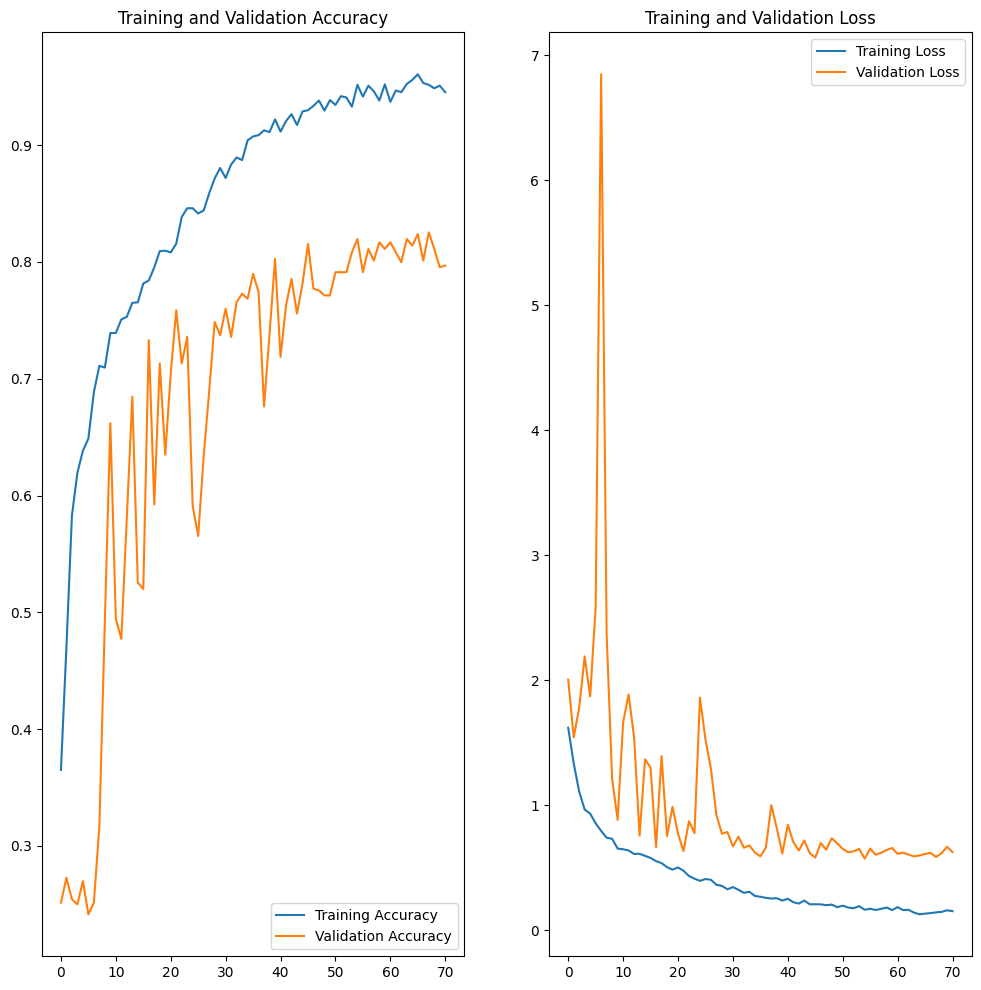

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(71)

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from keras.utils import load_img, img_to_array

image_path_test_bcc = list(data_dir_test.glob('bcc/*.jpg'))
df_bcc = pd.DataFrame(image_path_test_bcc, columns=['images'])
df_bcc['classes']='bcc'

image_path_test_bkl = list(data_dir_test.glob('bkl/*.jpg'))
df_bkl = pd.DataFrame(image_path_test_bkl, columns=['images'])
df_bkl['classes']='bkl'

image_path_test_mel = list(data_dir_test.glob('mel/*.jpg'))
df_mel = pd.DataFrame(image_path_test_mel, columns=['images'])
df_mel['classes']='mel'

image_path_test_nv = list(data_dir_test.glob('nv/*.jpg'))
df_nv = pd.DataFrame(image_path_test_nv, columns=['images'])
df_nv['classes']='nv'

df_teste = pd.concat([df_bcc, df_bkl, df_mel, df_nv], ignore_index=True)

imgs = []
for image_name in df_teste['images'].values:
   img = load_img(image_name, target_size = (img_height, img_width), color_mode = 'rgb')
   img_array = img_to_array(img)
   img_array = img_array/255.
   imgs.append(img_array)
imgs = np.array(imgs)

In [ ]:
#Carregando o melhor conjunto de pesos
model_test_5 = tf.keras.models.load_model(path_check_point_model_5)

#Realizando a predição no modelo treinado
y_predict = model_test_5.predict(imgs, verbose=1)
class_pred = []

for pred in y_predict:
  class_number = np.argmax(pred)
  if class_number == 0:
    class_pred.append('bcc')
  elif class_number == 1:
    class_pred.append('bkl')
  elif class_number == 2:
    class_pred.append('mel')
  else:
    class_pred.append('nv')

y_true = df_teste['classes'].values

6/6 [==============================] - 4s 536ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

erro, acurácia = model_test_5.evaluate(test_generator, batch_size = batch_size)
print(classification_report(y_true, class_pred, target_names = ['bcc','bkl','mel','nv']))
print('\n')
print('Erro:', format(erro, '.2f'), '\nAcurácia:', format(acurácia, '.2f'))

6/6 [==============================] - 4s 370ms/step - loss: 0.6430 - accuracy: 0.7722
              precision    recall  f1-score   support

         bcc       0.88      0.96      0.91        45
         bkl       0.66      0.78      0.71        45
         mel       0.72      0.62      0.67        45
          nv       0.85      0.73      0.79        45

    accuracy                           0.77       180
   macro avg       0.78      0.77      0.77       180
weighted avg       0.78      0.77      0.77       180



Erro: 0.64 
Acurácia: 0.77


In [ ]:
pred_aux = class_pred.copy()

for i in list(range(0, 45, 1)):
  if pred_aux[i] != 'bcc':
    pred_aux[i] = 'non_bcc'

for i in list(range(45, 90, 1)):
  if pred_aux[i] != 'bkl':
    pred_aux[i] = 'non_bkl'

for i in list(range(90, 135, 1)):
  if pred_aux[i] != 'mel':
    pred_aux[i] = 'non_mel'

for i in list(range(135, 180, 1)):
  if pred_aux[i] != 'nv':
    pred_aux[i] = 'non_nv'

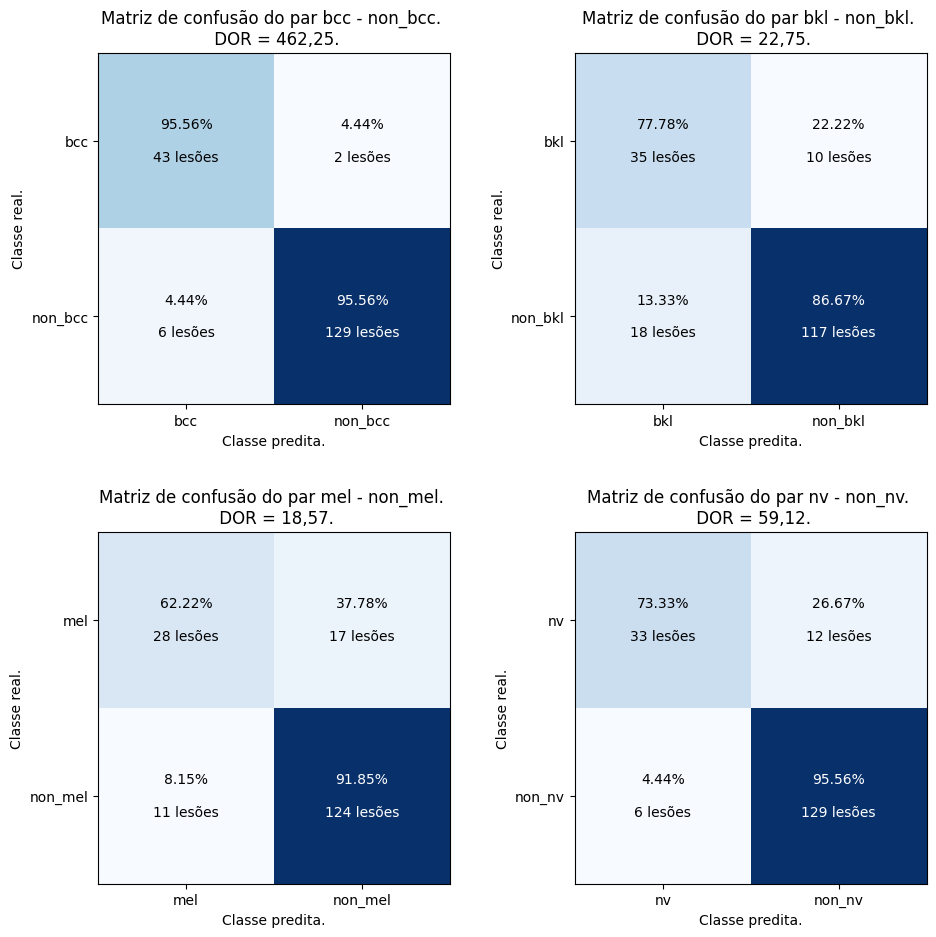

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

classes_pair = [['bcc','non_bcc'], ['bkl','non_bkl'], ['mel','non_mel'], ['nv', 'non_nv']]
cm = []
dor = []

for i in range(len(classes_pair)):
  aux_true = []
  aux_pred = []

  aux_true = [x if x == classes_pair[i][0] else classes_pair[i][1] for x in y_true]
  aux_pred = [y if y == classes_pair[i][0] else classes_pair[i][1] for y in class_pred]

  cm_aux = confusion_matrix(aux_true, aux_pred, normalize=None , labels=classes_pair[i])
  cm.append(cm_aux)

  if cm_aux[0,1] == 0 or cm_aux[1,0] == 0 or cm_aux[0,1] == 0:
    dor.append('Não se define')
  else:
    dor_aux = round((cm_aux[0,0]/cm_aux[0,1])/(cm_aux[1,0]/cm_aux[1,1]), 2)
    dor.append(dor_aux)

dor = [str(i) for i in dor]
dor = [i.replace('.',',') for i in dor]


plt.figure(figsize = (10, 10))

for i in range(len(classes_pair)):
  ax=plt.subplot(2, 2, i+1)
  title=f'Matriz de confusão do par {classes_pair[i][0]} - {classes_pair[i][1]}. \n DOR = {dor[i]}.'
  plt.imshow(cm[i], interpolation='nearest', cmap=plt.cm.Blues)
  plt.title(title)
  tick_marks = np.arange(len(classes_pair[i]))
  plt.xticks(tick_marks, classes_pair[i], rotation=0)
  plt.yticks(tick_marks, classes_pair[i])
  thresh = cm[i].max() / 2.
  for k, p in itertools.product(range(cm[i].shape[0]), range(cm[i].shape[1])):
    if k == 0:
        plt.text(p, k, format(cm[i][k, p]*100/45, '.2f')+'%\n\n'+format(cm[i][k, p], '.0f') + ' lesões',
        horizontalalignment="center",
        verticalalignment="center",
        color="white" if cm[i][k, p] > thresh else "black",
        )
    else:
        plt.text(p, k, format(cm[i][k, p]*100/135, '.2f')+'%\n\n'+format(cm[i][k, p], '.0f') + ' lesões',
        horizontalalignment="center",
        verticalalignment="center",
        color="white" if cm[i][k, p] > thresh else "black",
        )

    plt.ylabel('Classe real.')
    plt.xlabel('Classe predita.')
    plt.tight_layout(pad = 3)

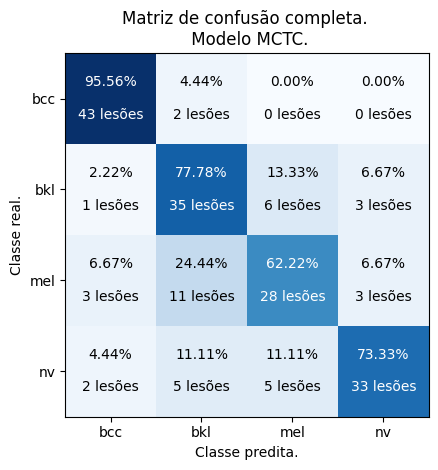

In [ ]:
import itertools

#Plotando a matriz de confusão
class_names=['bcc','bkl','mel','nv']
cm=confusion_matrix(y_true, class_pred, normalize='true')
title='Matriz de confusão completa. \n Modelo MCTC.'
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks, class_names)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, format(cm[i, j]*100, '.2f')+'%\n\n'+format(cm[i, j]*45, '.0f') + ' lesões',
  horizontalalignment="center",
  verticalalignment="center",
  color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Classe real.')
plt.xlabel('Classe predita.')
plt.tight_layout()

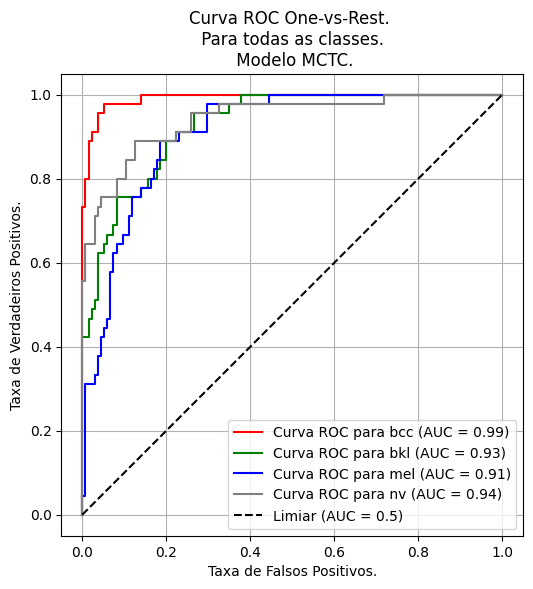

In [ ]:
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))

class_pred_bin = LabelBinarizer().fit(y_true)
y_true_bin = class_pred_bin.transform(y_true)

colors = cycle(["red","green","blue","gray"])
classes = class_pred_bin.classes_
n_classes = len(np.unique(classes))
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(y_true_bin[:, class_id],
                                     y_predict[:, class_id],
                                     name=f"Curva ROC para {classes[class_id]}",
                                     color=color,
                                     ax=ax
                                     )

plt.plot([0, 1], [0, 1], "k--", label="Limiar (AUC = 0.5)")
plt.axis("square")
plt.xlabel("Taxa de Falsos Positivos.")
plt.ylabel("Taxa de Verdadeiros Positivos.")
plt.title("Curva ROC One-vs-Rest. \n Para todas as classes. \n Modelo MCTC.")
plt.legend()
plt.grid()
plt.show()

##*Teste - 3200 imagens*

Teste com um total de 3200 imagens, sendo, 2400 para treinamento, 640 para validação e 160 para teste. As transformações realizadas nas imagens pertecentes à base de treinamento são:

```
horizontal_flip=True,
vertical_flip=False,
height_shift_range=0.1,
width_shift_range=0.1,
rotation_range=30,
zoom_range=0.125,
```

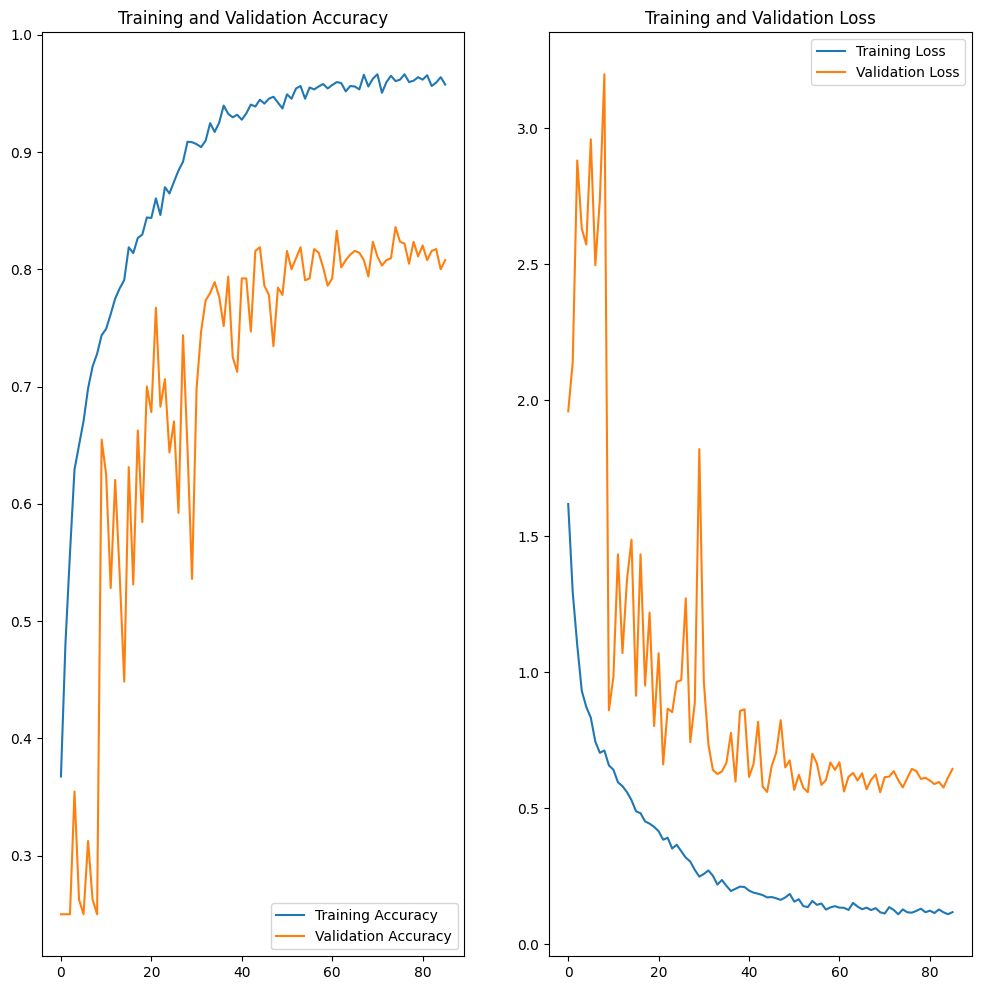

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(86)

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from keras.utils import load_img, img_to_array

image_path_test_bcc = list(data_dir_test.glob('bcc/*.jpg'))
df_bcc = pd.DataFrame(image_path_test_bcc, columns=['images'])
df_bcc['classes']='bcc'

image_path_test_bkl = list(data_dir_test.glob('bkl/*.jpg'))
df_bkl = pd.DataFrame(image_path_test_bkl, columns=['images'])
df_bkl['classes']='bkl'

image_path_test_mel = list(data_dir_test.glob('mel/*.jpg'))
df_mel = pd.DataFrame(image_path_test_mel, columns=['images'])
df_mel['classes']='mel'

image_path_test_nv = list(data_dir_test.glob('nv/*.jpg'))
df_nv = pd.DataFrame(image_path_test_nv, columns=['images'])
df_nv['classes']='nv'

df_teste = pd.concat([df_bcc, df_bkl, df_mel, df_nv], ignore_index=True)

imgs = []
for image_name in df_teste['images'].values:
   img = load_img(image_name, target_size = (img_height, img_width), color_mode = 'rgb')
   img_array = img_to_array(img)
   img_array = img_array/255.
   imgs.append(img_array)
imgs = np.array(imgs)

In [ ]:
#Carregando o melhor conjunto de pesos
model_test_5 = tf.keras.models.load_model(path_check_point_model_5)

#Realizando a predição no modelo treinado
y_predict = model_test_5.predict(imgs, verbose=1)
class_pred = []

for pred in y_predict:
  class_number = np.argmax(pred)
  if class_number == 0:
    class_pred.append('bcc')
  elif class_number == 1:
    class_pred.append('bkl')
  elif class_number == 2:
    class_pred.append('mel')
  else:
    class_pred.append('nv')

y_true = df_teste['classes'].values

5/5 [==============================] - 2s 131ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

erro, acurácia = model_test_5.evaluate(test_generator, batch_size = batch_size)
print(classification_report(y_true, class_pred, target_names = ['bcc','bkl','mel','nv']))
print('\n')
print('Erro:', format(erro, '.2f'), '\nAcurácia:', format(acurácia, '.2f'))

5/5 [==============================] - 5s 480ms/step - loss: 0.6278 - accuracy: 0.7812
              precision    recall  f1-score   support

         bcc       0.95      0.93      0.94        40
         bkl       0.70      0.80      0.74        40
         mel       0.64      0.57      0.61        40
          nv       0.85      0.82      0.84        40

    accuracy                           0.78       160
   macro avg       0.78      0.78      0.78       160
weighted avg       0.78      0.78      0.78       160



Erro: 0.63 
Acurácia: 0.78


In [ ]:
pred_aux = class_pred.copy()

for i in list(range(0, 40, 1)):
  if pred_aux[i] != 'bcc':
    pred_aux[i] = 'non_bcc'

for i in list(range(40, 80, 1)):
  if pred_aux[i] != 'bkl':
    pred_aux[i] = 'non_bkl'

for i in list(range(80, 120, 1)):
  if pred_aux[i] != 'mel':
    pred_aux[i] = 'non_mel'

for i in list(range(120, 160, 1)):
  if pred_aux[i] != 'nv':
    pred_aux[i] = 'non_nv'

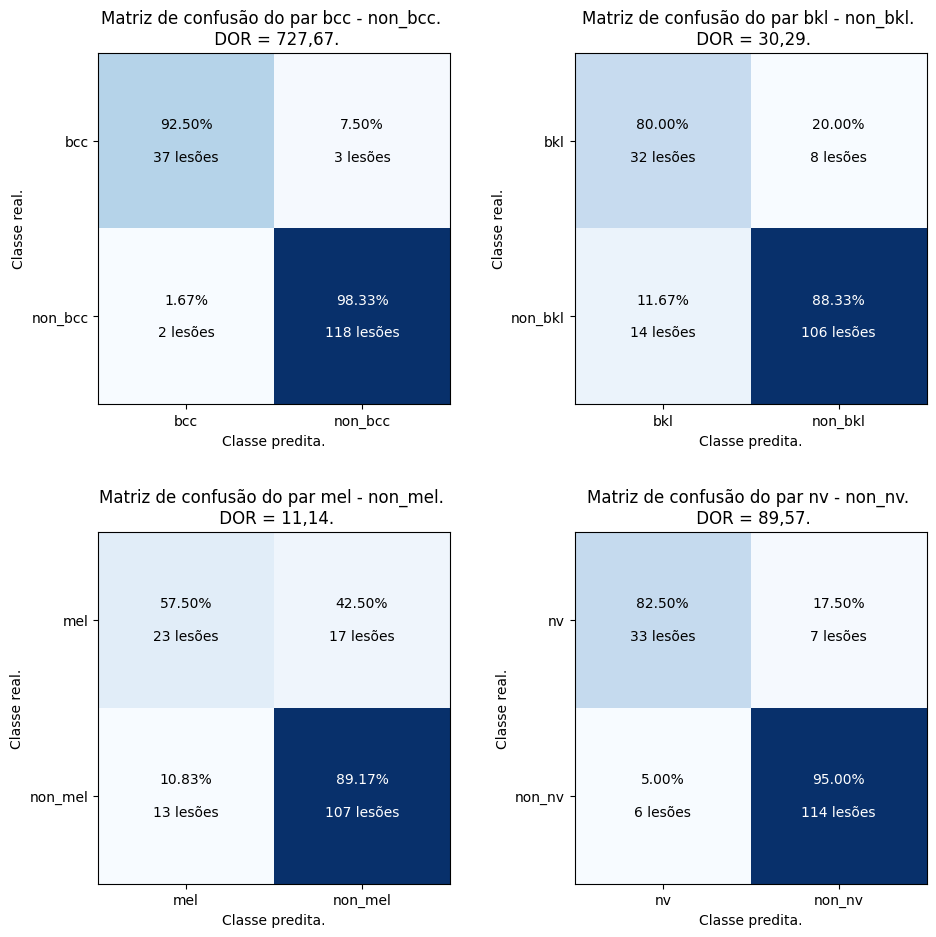

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

classes_pair = [['bcc','non_bcc'], ['bkl','non_bkl'], ['mel','non_mel'], ['nv', 'non_nv']]
cm = []
dor = []

for i in range(len(classes_pair)):
  aux_true = []
  aux_pred = []

  aux_true = [x if x == classes_pair[i][0] else classes_pair[i][1] for x in y_true]
  aux_pred = [y if y == classes_pair[i][0] else classes_pair[i][1] for y in class_pred]

  cm_aux = confusion_matrix(aux_true, aux_pred, normalize=None , labels=classes_pair[i])
  cm.append(cm_aux)

  if cm_aux[0,1] == 0 or cm_aux[1,0] == 0 or cm_aux[0,1] == 0:
    dor.append('Não se define')
  else:
    dor_aux = round((cm_aux[0,0]/cm_aux[0,1])/(cm_aux[1,0]/cm_aux[1,1]), 2)
    dor.append(dor_aux)

dor = [str(i) for i in dor]
dor = [i.replace('.',',') for i in dor]


plt.figure(figsize = (10, 10))

for i in range(len(classes_pair)):
  ax=plt.subplot(2, 2, i+1)
  title=f'Matriz de confusão do par {classes_pair[i][0]} - {classes_pair[i][1]}. \n DOR = {dor[i]}.'
  plt.imshow(cm[i], interpolation='nearest', cmap=plt.cm.Blues)
  plt.title(title)
  tick_marks = np.arange(len(classes_pair[i]))
  plt.xticks(tick_marks, classes_pair[i], rotation=0)
  plt.yticks(tick_marks, classes_pair[i])
  thresh = cm[i].max() / 2.
  for k, p in itertools.product(range(cm[i].shape[0]), range(cm[i].shape[1])):
    if k == 0:
        plt.text(p, k, format(cm[i][k, p]*100/40, '.2f')+'%\n\n'+format(cm[i][k, p], '.0f') + ' lesões',
        horizontalalignment="center",
        verticalalignment="center",
        color="white" if cm[i][k, p] > thresh else "black",
        )
    else:
        plt.text(p, k, format(cm[i][k, p]*100/120, '.2f')+'%\n\n'+format(cm[i][k, p], '.0f') + ' lesões',
        horizontalalignment="center",
        verticalalignment="center",
        color="white" if cm[i][k, p] > thresh else "black",
        )

    plt.ylabel('Classe real.')
    plt.xlabel('Classe predita.')
    plt.tight_layout(pad = 3)

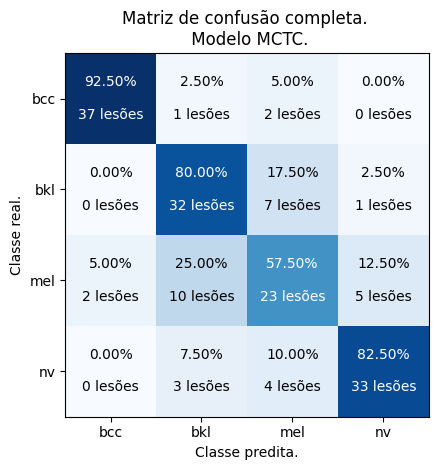

In [ ]:
import itertools

#Plotando a matriz de confusão
class_names=['bcc','bkl','mel','nv']
cm=confusion_matrix(y_true, class_pred, normalize='true')
title='Matriz de confusão completa. \n Modelo MCTC.'
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks, class_names)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, format(cm[i, j]*100, '.2f')+'%\n\n'+format(cm[i, j]*40, '.0f') + ' lesões',
  horizontalalignment="center",
  verticalalignment="center",
  color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Classe real.')
plt.xlabel('Classe predita.')
plt.tight_layout()

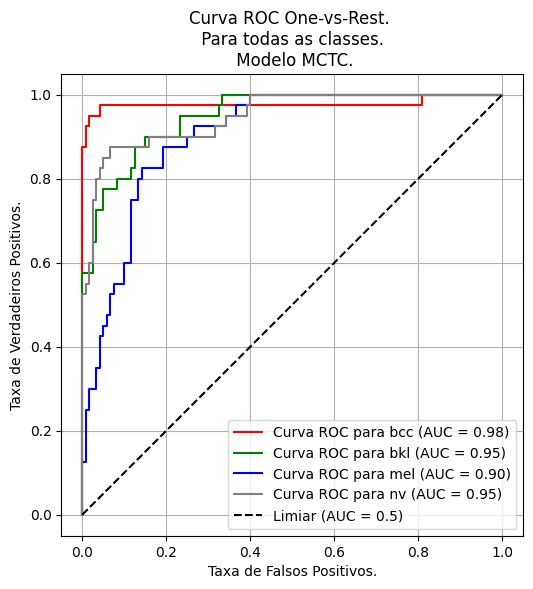

In [ ]:
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))

class_pred_bin = LabelBinarizer().fit(y_true)
y_true_bin = class_pred_bin.transform(y_true)

colors = cycle(["red","green","blue","gray"])
classes = class_pred_bin.classes_
n_classes = len(np.unique(classes))
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(y_true_bin[:, class_id],
                                     y_predict[:, class_id],
                                     name=f"Curva ROC para {classes[class_id]}",
                                     color=color,
                                     ax=ax
                                     )

plt.plot([0, 1], [0, 1], "k--", label="Limiar (AUC = 0.5)")
plt.axis("square")
plt.xlabel("Taxa de Falsos Positivos.")
plt.ylabel("Taxa de Verdadeiros Positivos.")
plt.title("Curva ROC One-vs-Rest. \n Para todas as classes. \n Modelo MCTC.")
plt.legend()
plt.grid()
plt.show()

##*Teste - 2800 imagens*

Teste com um total de 2800 imagens, sendo, 2100 para treinamento, 560 para validação e 140 para teste. As transformações realizadas nas imagens pertecentes à base de treinamento são:

```
horizontal_flip=True,
vertical_flip=False,
height_shift_range=0.1,
width_shift_range=0.1,
rotation_range=30,
zoom_range=0.125,
```

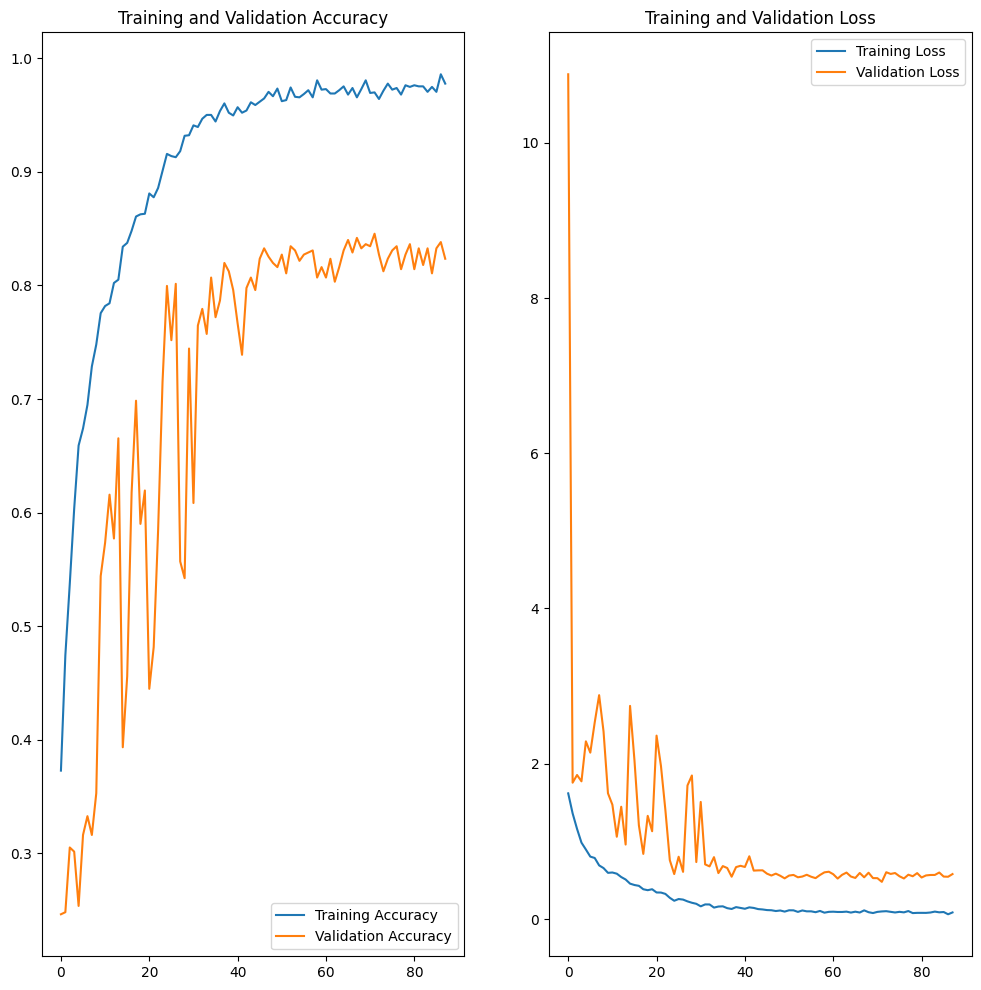

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(88)

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from keras.utils import load_img, img_to_array

image_path_test_bcc = list(data_dir_test.glob('bcc/*.jpg'))
df_bcc = pd.DataFrame(image_path_test_bcc, columns=['images'])
df_bcc['classes']='bcc'

image_path_test_bkl = list(data_dir_test.glob('bkl/*.jpg'))
df_bkl = pd.DataFrame(image_path_test_bkl, columns=['images'])
df_bkl['classes']='bkl'

image_path_test_mel = list(data_dir_test.glob('mel/*.jpg'))
df_mel = pd.DataFrame(image_path_test_mel, columns=['images'])
df_mel['classes']='mel'

image_path_test_nv = list(data_dir_test.glob('nv/*.jpg'))
df_nv = pd.DataFrame(image_path_test_nv, columns=['images'])
df_nv['classes']='nv'

df_teste = pd.concat([df_bcc, df_bkl, df_mel, df_nv], ignore_index=True)

imgs = []
for image_name in df_teste['images'].values:
   img = load_img(image_name, target_size = (img_height, img_width), color_mode = 'rgb')
   img_array = img_to_array(img)
   img_array = img_array/255.
   imgs.append(img_array)
imgs = np.array(imgs)

In [ ]:
#Carregando o melhor conjunto de pesos
model_test_5 = tf.keras.models.load_model(path_check_point_model_5)

#Realizando a predição no modelo treinado
y_predict = model_test_5.predict(imgs, verbose=1)
class_pred = []

for pred in y_predict:
  class_number = np.argmax(pred)
  if class_number == 0:
    class_pred.append('bcc')
  elif class_number == 1:
    class_pred.append('bkl')
  elif class_number == 2:
    class_pred.append('mel')
  else:
    class_pred.append('nv')

y_true = df_teste['classes'].values

5/5 [==============================] - 4s 544ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

erro, acurácia = model_test_5.evaluate(test_generator, batch_size = batch_size)
print(classification_report(y_true, class_pred, target_names = ['bcc','bkl','mel','nv']))
print('\n')
print('Erro:', format(erro, '.2f'), '\nAcurácia:', format(acurácia, '.2f'))

5/5 [==============================] - 3s 336ms/step - loss: 0.7817 - accuracy: 0.8071
              precision    recall  f1-score   support

         bcc       0.94      0.94      0.94        35
         bkl       0.70      0.74      0.72        35
         mel       0.74      0.74      0.74        35
          nv       0.85      0.80      0.82        35

    accuracy                           0.81       140
   macro avg       0.81      0.81      0.81       140
weighted avg       0.81      0.81      0.81       140



Erro: 0.78 
Acurácia: 0.81


In [ ]:
pred_aux = class_pred.copy()

for i in list(range(0, 35, 1)):
  if pred_aux[i] != 'bcc':
    pred_aux[i] = 'non_bcc'

for i in list(range(35, 70, 1)):
  if pred_aux[i] != 'bkl':
    pred_aux[i] = 'non_bkl'

for i in list(range(70, 105, 1)):
  if pred_aux[i] != 'mel':
    pred_aux[i] = 'non_mel'

for i in list(range(105, 140, 1)):
  if pred_aux[i] != 'nv':
    pred_aux[i] = 'non_nv'

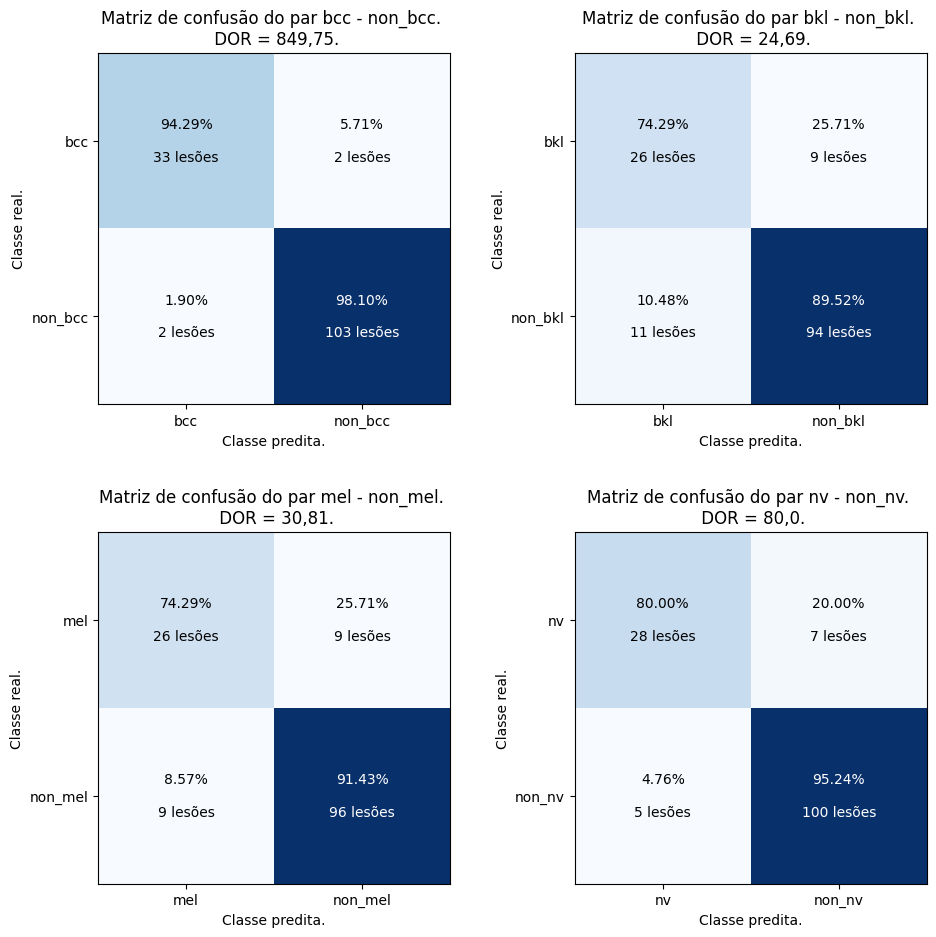

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

classes_pair = [['bcc','non_bcc'], ['bkl','non_bkl'], ['mel','non_mel'], ['nv', 'non_nv']]
cm = []
dor = []

for i in range(len(classes_pair)):
  aux_true = []
  aux_pred = []

  aux_true = [x if x == classes_pair[i][0] else classes_pair[i][1] for x in y_true]
  aux_pred = [y if y == classes_pair[i][0] else classes_pair[i][1] for y in class_pred]

  cm_aux = confusion_matrix(aux_true, aux_pred, normalize=None , labels=classes_pair[i])
  cm.append(cm_aux)

  if cm_aux[0,1] == 0 or cm_aux[1,0] == 0 or cm_aux[0,1] == 0:
    dor.append('Não se define')
  else:
    dor_aux = round((cm_aux[0,0]/cm_aux[0,1])/(cm_aux[1,0]/cm_aux[1,1]), 2)
    dor.append(dor_aux)

dor = [str(i) for i in dor]
dor = [i.replace('.',',') for i in dor]


plt.figure(figsize = (10, 10))

for i in range(len(classes_pair)):
  ax=plt.subplot(2, 2, i+1)
  title=f'Matriz de confusão do par {classes_pair[i][0]} - {classes_pair[i][1]}. \n DOR = {dor[i]}.'
  plt.imshow(cm[i], interpolation='nearest', cmap=plt.cm.Blues)
  plt.title(title)
  tick_marks = np.arange(len(classes_pair[i]))
  plt.xticks(tick_marks, classes_pair[i], rotation=0)
  plt.yticks(tick_marks, classes_pair[i])
  thresh = cm[i].max() / 2.
  for k, p in itertools.product(range(cm[i].shape[0]), range(cm[i].shape[1])):
    if k == 0:
        plt.text(p, k, format(cm[i][k, p]*100/35, '.2f')+'%\n\n'+format(cm[i][k, p], '.0f') + ' lesões',
        horizontalalignment="center",
        verticalalignment="center",
        color="white" if cm[i][k, p] > thresh else "black",
        )
    else:
        plt.text(p, k, format(cm[i][k, p]*100/105, '.2f')+'%\n\n'+format(cm[i][k, p], '.0f') + ' lesões',
        horizontalalignment="center",
        verticalalignment="center",
        color="white" if cm[i][k, p] > thresh else "black",
        )

    plt.ylabel('Classe real.')
    plt.xlabel('Classe predita.')
    plt.tight_layout(pad = 3)

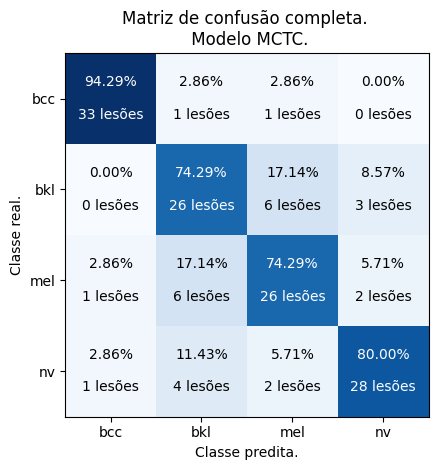

In [ ]:
import itertools

#Plotando a matriz de confusão
class_names=['bcc','bkl','mel','nv']
cm=confusion_matrix(y_true, class_pred, normalize='true')
title='Matriz de confusão completa. \n Modelo MCTC.'
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks, class_names)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, format(cm[i, j]*100, '.2f')+'%\n\n'+format(cm[i, j]*35, '.0f') + ' lesões',
  horizontalalignment="center",
  verticalalignment="center",
  color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Classe real.')
plt.xlabel('Classe predita.')
plt.tight_layout()

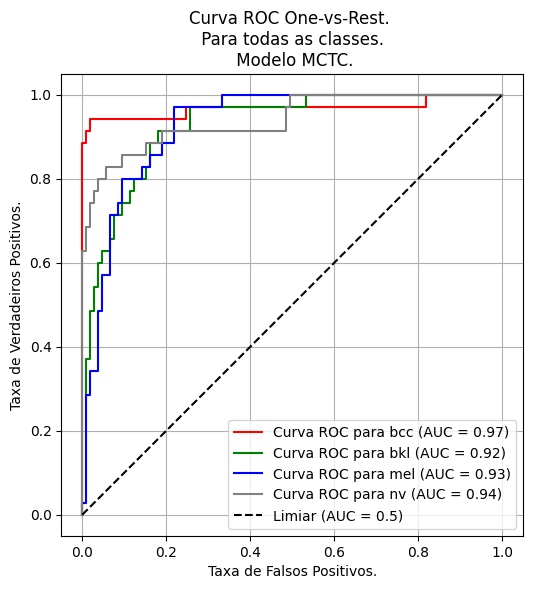

In [ ]:
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))

class_pred_bin = LabelBinarizer().fit(y_true)
y_true_bin = class_pred_bin.transform(y_true)

colors = cycle(["red","green","blue","gray"])
classes = class_pred_bin.classes_
n_classes = len(np.unique(classes))
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(y_true_bin[:, class_id],
                                     y_predict[:, class_id],
                                     name=f"Curva ROC para {classes[class_id]}",
                                     color=color,
                                     ax=ax
                                     )

plt.plot([0, 1], [0, 1], "k--", label="Limiar (AUC = 0.5)")
plt.axis("square")
plt.xlabel("Taxa de Falsos Positivos.")
plt.ylabel("Taxa de Verdadeiros Positivos.")
plt.title("Curva ROC One-vs-Rest. \n Para todas as classes. \n Modelo MCTC.")
plt.legend()
plt.grid()
plt.show()

##*Teste - 2400 imagens*

Teste com um total de 2400 imagens, sendo, 1800 para treinamento, 480 para validação e 120 para teste. As transformações realizadas nas imagens pertecentes à base de treinamento são:

```
horizontal_flip=True,
vertical_flip=False,
height_shift_range=0.1,
width_shift_range=0.1,
rotation_range=30,
zoom_range=0.125,
```

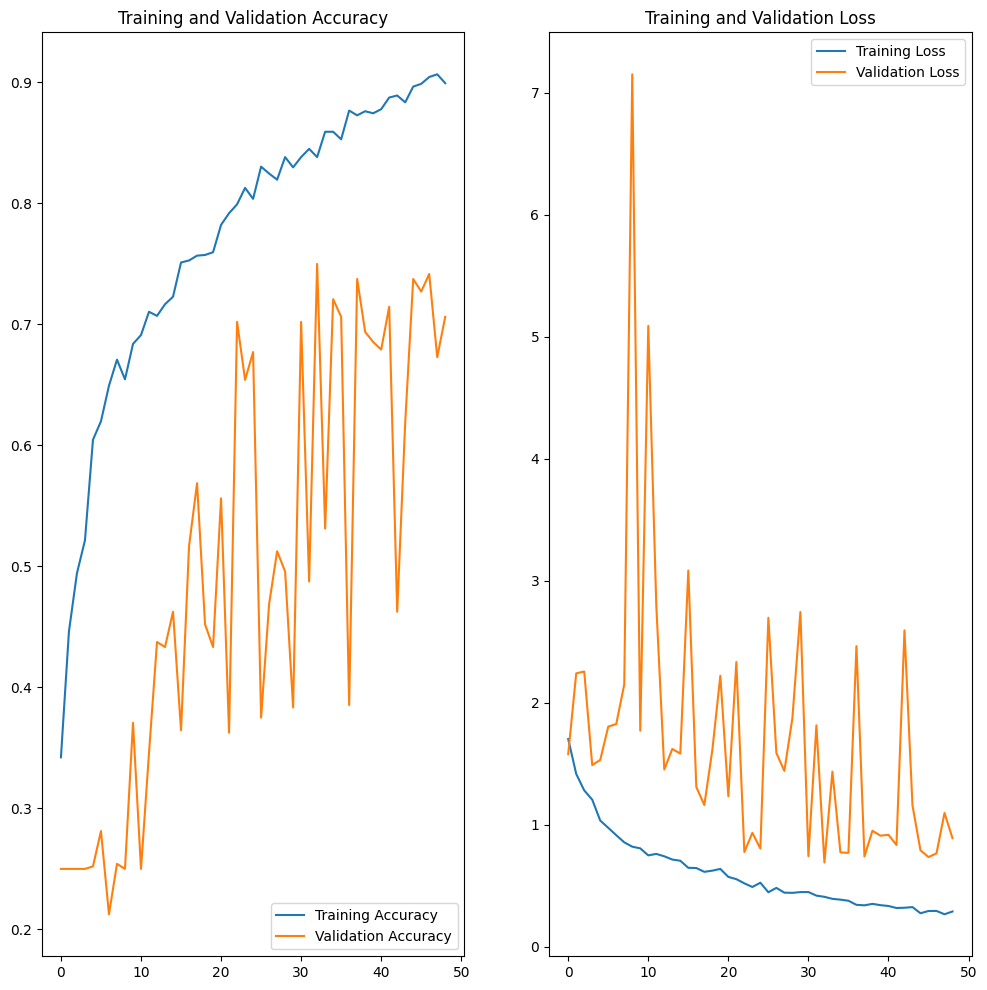

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(49)

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from keras.utils import load_img, img_to_array

image_path_test_bcc = list(data_dir_test.glob('bcc/*.jpg'))
df_bcc = pd.DataFrame(image_path_test_bcc, columns=['images'])
df_bcc['classes']='bcc'

image_path_test_bkl = list(data_dir_test.glob('bkl/*.jpg'))
df_bkl = pd.DataFrame(image_path_test_bkl, columns=['images'])
df_bkl['classes']='bkl'

image_path_test_mel = list(data_dir_test.glob('mel/*.jpg'))
df_mel = pd.DataFrame(image_path_test_mel, columns=['images'])
df_mel['classes']='mel'

image_path_test_nv = list(data_dir_test.glob('nv/*.jpg'))
df_nv = pd.DataFrame(image_path_test_nv, columns=['images'])
df_nv['classes']='nv'

df_teste = pd.concat([df_bcc, df_bkl, df_mel, df_nv], ignore_index=True)

imgs = []
for image_name in df_teste['images'].values:
   img = load_img(image_name, target_size = (img_height, img_width), color_mode = 'rgb')
   img_array = img_to_array(img)
   img_array = img_array/255.
   imgs.append(img_array)
imgs = np.array(imgs)

In [ ]:
#Carregando o melhor conjunto de pesos
model_test_5 = tf.keras.models.load_model(path_check_point_model_5)

#Realizando a predição no modelo treinado
y_predict = model_test_5.predict(imgs, verbose=1)
class_pred = []

for pred in y_predict:
  class_number = np.argmax(pred)
  if class_number == 0:
    class_pred.append('bcc')
  elif class_number == 1:
    class_pred.append('bkl')
  elif class_number == 2:
    class_pred.append('mel')
  else:
    class_pred.append('nv')

y_true = df_teste['classes'].values

4/4 [==============================] - 4s 928ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

erro, acurácia = model_test_5.evaluate(test_generator, batch_size = batch_size)
print(classification_report(y_true, class_pred, target_names = ['bcc','bkl','mel','nv']))
print('\n')
print('Erro:', format(erro, '.2f'), '\nAcurácia:', format(acurácia, '.2f'))

4/4 [==============================] - 3s 408ms/step - loss: 0.7604 - accuracy: 0.6750
              precision    recall  f1-score   support

         bcc       0.81      0.83      0.82        30
         bkl       0.51      0.83      0.63        30
         mel       0.67      0.33      0.44        30
          nv       0.84      0.70      0.76        30

    accuracy                           0.68       120
   macro avg       0.71      0.68      0.67       120
weighted avg       0.71      0.68      0.67       120



Erro: 0.76 
Acurácia: 0.68


In [ ]:
pred_aux = class_pred.copy()

for i in list(range(0, 30, 1)):
  if pred_aux[i] != 'bcc':
    pred_aux[i] = 'non_bcc'

for i in list(range(30, 60, 1)):
  if pred_aux[i] != 'bkl':
    pred_aux[i] = 'non_bkl'

for i in list(range(60, 90, 1)):
  if pred_aux[i] != 'mel':
    pred_aux[i] = 'non_mel'

for i in list(range(90, 120, 1)):
  if pred_aux[i] != 'nv':
    pred_aux[i] = 'non_nv'

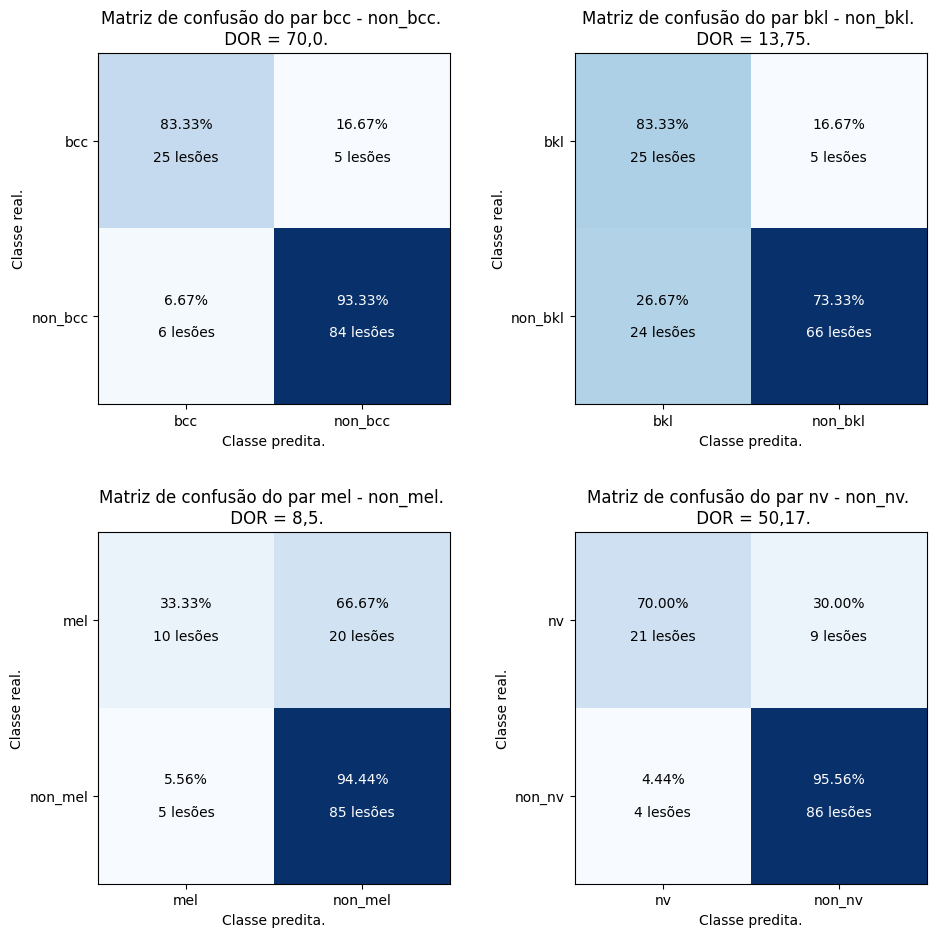

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

classes_pair = [['bcc','non_bcc'], ['bkl','non_bkl'], ['mel','non_mel'], ['nv', 'non_nv']]
cm = []
dor = []

for i in range(len(classes_pair)):
  aux_true = []
  aux_pred = []

  aux_true = [x if x == classes_pair[i][0] else classes_pair[i][1] for x in y_true]
  aux_pred = [y if y == classes_pair[i][0] else classes_pair[i][1] for y in class_pred]

  cm_aux = confusion_matrix(aux_true, aux_pred, normalize=None , labels=classes_pair[i])
  cm.append(cm_aux)

  if cm_aux[0,1] == 0 or cm_aux[1,0] == 0 or cm_aux[0,1] == 0:
    dor.append('Não se define')
  else:
    dor_aux = round((cm_aux[0,0]/cm_aux[0,1])/(cm_aux[1,0]/cm_aux[1,1]), 2)
    dor.append(dor_aux)

dor = [str(i) for i in dor]
dor = [i.replace('.',',') for i in dor]


plt.figure(figsize = (10, 10))

for i in range(len(classes_pair)):
  ax=plt.subplot(2, 2, i+1)
  title=f'Matriz de confusão do par {classes_pair[i][0]} - {classes_pair[i][1]}. \n DOR = {dor[i]}.'
  plt.imshow(cm[i], interpolation='nearest', cmap=plt.cm.Blues)
  plt.title(title)
  tick_marks = np.arange(len(classes_pair[i]))
  plt.xticks(tick_marks, classes_pair[i], rotation=0)
  plt.yticks(tick_marks, classes_pair[i])
  thresh = cm[i].max() / 2.
  for k, p in itertools.product(range(cm[i].shape[0]), range(cm[i].shape[1])):
    if k == 0:
        plt.text(p, k, format(cm[i][k, p]*100/30, '.2f')+'%\n\n'+format(cm[i][k, p], '.0f') + ' lesões',
        horizontalalignment="center",
        verticalalignment="center",
        color="white" if cm[i][k, p] > thresh else "black",
        )
    else:
        plt.text(p, k, format(cm[i][k, p]*100/90, '.2f')+'%\n\n'+format(cm[i][k, p], '.0f') + ' lesões',
        horizontalalignment="center",
        verticalalignment="center",
        color="white" if cm[i][k, p] > thresh else "black",
        )

    plt.ylabel('Classe real.')
    plt.xlabel('Classe predita.')
    plt.tight_layout(pad = 3)

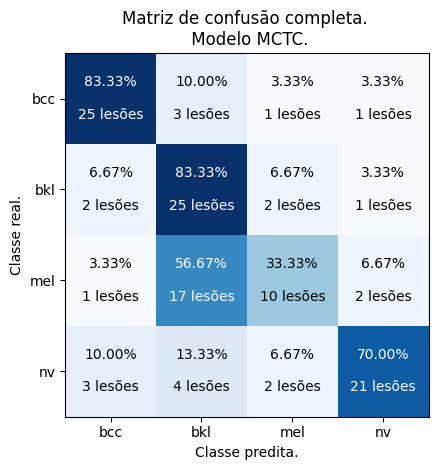

In [ ]:
import itertools

#Plotando a matriz de confusão
class_names=['bcc','bkl','mel','nv']
cm=confusion_matrix(y_true, class_pred, normalize='true')
title='Matriz de confusão completa. \n Modelo MCTC.'
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks, class_names)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, format(cm[i, j]*100, '.2f')+'%\n\n'+format(cm[i, j]*30, '.0f') + ' lesões',
  horizontalalignment="center",
  verticalalignment="center",
  color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Classe real.')
plt.xlabel('Classe predita.')
plt.tight_layout()

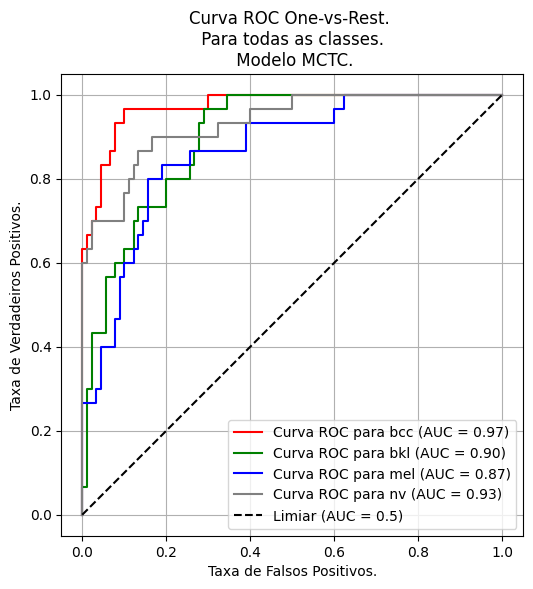

In [ ]:
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))

class_pred_bin = LabelBinarizer().fit(y_true)
y_true_bin = class_pred_bin.transform(y_true)

colors = cycle(["red","green","blue","gray"])
classes = class_pred_bin.classes_
n_classes = len(np.unique(classes))
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(y_true_bin[:, class_id],
                                     y_predict[:, class_id],
                                     name=f"Curva ROC para {classes[class_id]}",
                                     color=color,
                                     ax=ax
                                     )

plt.plot([0, 1], [0, 1], "k--", label="Limiar (AUC = 0.5)")
plt.axis("square")
plt.xlabel("Taxa de Falsos Positivos.")
plt.ylabel("Taxa de Verdadeiros Positivos.")
plt.title("Curva ROC One-vs-Rest. \n Para todas as classes. \n Modelo MCTC.")
plt.legend()
plt.grid()
plt.show()

##*Teste - 2000 imagens*

Teste com um total de 2000 imagens, sendo, 1500 para treinamento, 400 para validação e 100 para teste. As transformações realizadas nas imagens pertecentes à base de treinamento são:

```
horizontal_flip=True,
vertical_flip=False,
height_shift_range=0.1,
width_shift_range=0.1,
rotation_range=30,
zoom_range=0.125,
```

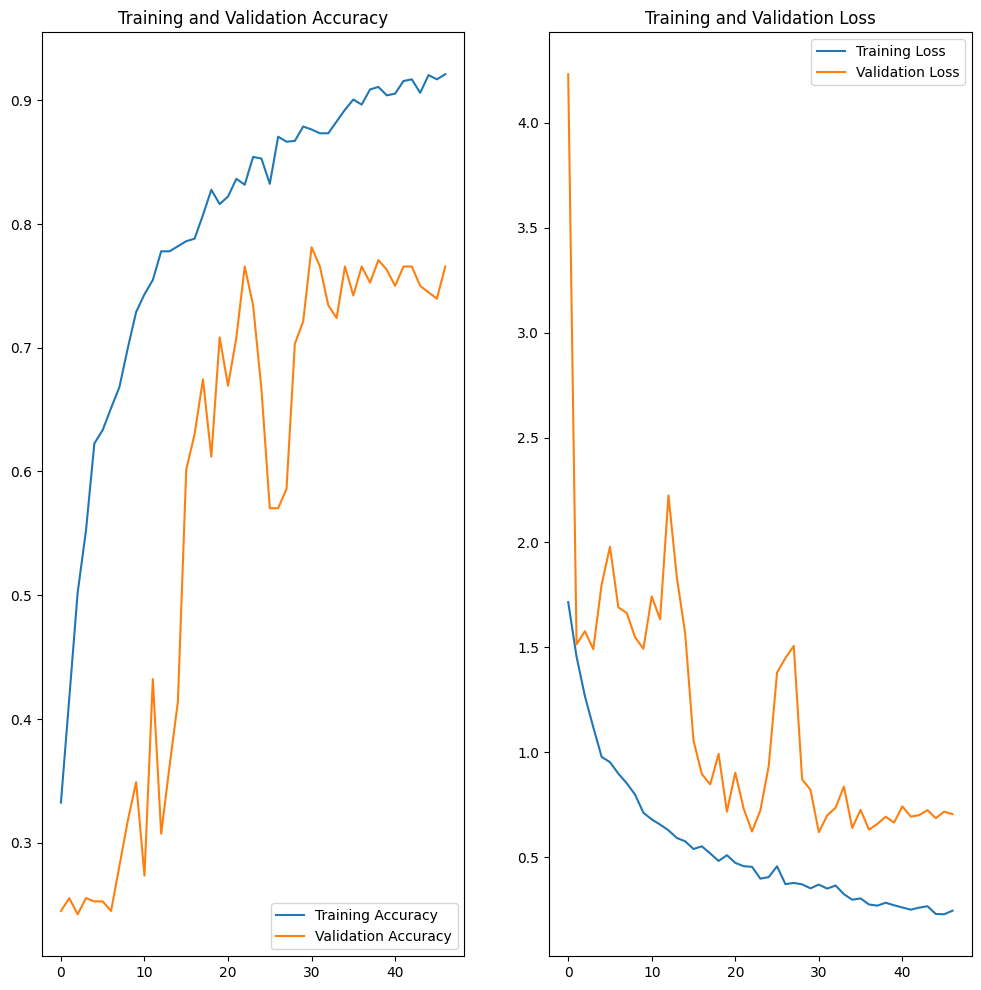

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(47)

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from keras.utils import load_img, img_to_array

image_path_test_bcc = list(data_dir_test.glob('bcc/*.jpg'))
df_bcc = pd.DataFrame(image_path_test_bcc, columns=['images'])
df_bcc['classes']='bcc'

image_path_test_bkl = list(data_dir_test.glob('bkl/*.jpg'))
df_bkl = pd.DataFrame(image_path_test_bkl, columns=['images'])
df_bkl['classes']='bkl'

image_path_test_mel = list(data_dir_test.glob('mel/*.jpg'))
df_mel = pd.DataFrame(image_path_test_mel, columns=['images'])
df_mel['classes']='mel'

image_path_test_nv = list(data_dir_test.glob('nv/*.jpg'))
df_nv = pd.DataFrame(image_path_test_nv, columns=['images'])
df_nv['classes']='nv'

df_teste = pd.concat([df_bcc, df_bkl, df_mel, df_nv], ignore_index=True)

imgs = []
for image_name in df_teste['images'].values:
   img = load_img(image_name, target_size = (img_height, img_width), color_mode = 'rgb')
   img_array = img_to_array(img)
   img_array = img_array/255.
   imgs.append(img_array)
imgs = np.array(imgs)

In [ ]:
#Carregando o melhor conjunto de pesos
model_test_5 = tf.keras.models.load_model(path_check_point_model_5)

#Realizando a predição no modelo treinado
y_predict = model_test_5.predict(imgs, verbose=1)
class_pred = []

for pred in y_predict:
  class_number = np.argmax(pred)
  if class_number == 0:
    class_pred.append('bcc')
  elif class_number == 1:
    class_pred.append('bkl')
  elif class_number == 2:
    class_pred.append('mel')
  else:
    class_pred.append('nv')

y_true = df_teste['classes'].values

4/4 [==============================] - 3s 529ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

erro, acurácia = model_test_5.evaluate(test_generator, batch_size = batch_size)
print(classification_report(y_true, class_pred, target_names = ['bcc','bkl','mel','nv']))
print('\n')
print('Erro:', format(erro, '.2f'), '\nAcurácia:', format(acurácia, '.2f'))

4/4 [==============================] - 3s 285ms/step - loss: 0.4568 - accuracy: 0.8100
              precision    recall  f1-score   support

         bcc       0.81      1.00      0.89        25
         bkl       0.68      0.76      0.72        25
         mel       0.89      0.68      0.77        25
          nv       0.91      0.80      0.85        25

    accuracy                           0.81       100
   macro avg       0.82      0.81      0.81       100
weighted avg       0.82      0.81      0.81       100



Erro: 0.46 
Acurácia: 0.81


In [ ]:
pred_aux = class_pred.copy()

for i in list(range(0, 25, 1)):
  if pred_aux[i] != 'bcc':
    pred_aux[i] = 'non_bcc'

for i in list(range(25, 50, 1)):
  if pred_aux[i] != 'bkl':
    pred_aux[i] = 'non_bkl'

for i in list(range(50, 75, 1)):
  if pred_aux[i] != 'mel':
    pred_aux[i] = 'non_mel'

for i in list(range(75, 100, 1)):
  if pred_aux[i] != 'nv':
    pred_aux[i] = 'non_nv'

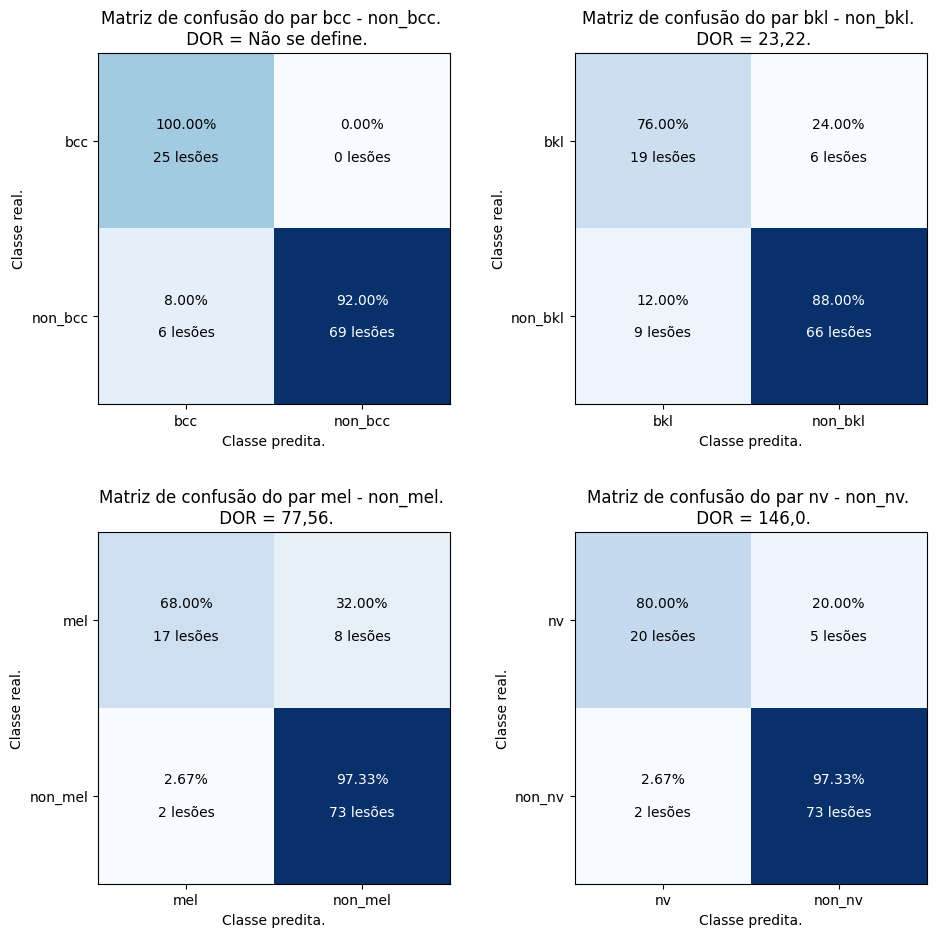

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

classes_pair = [['bcc','non_bcc'], ['bkl','non_bkl'], ['mel','non_mel'], ['nv', 'non_nv']]
cm = []
dor = []

for i in range(len(classes_pair)):
  aux_true = []
  aux_pred = []

  aux_true = [x if x == classes_pair[i][0] else classes_pair[i][1] for x in y_true]
  aux_pred = [y if y == classes_pair[i][0] else classes_pair[i][1] for y in class_pred]

  cm_aux = confusion_matrix(aux_true, aux_pred, normalize=None , labels=classes_pair[i])
  cm.append(cm_aux)

  if cm_aux[0,1] == 0 or cm_aux[1,0] == 0 or cm_aux[0,1] == 0:
    dor.append('Não se define')
  else:
    dor_aux = round((cm_aux[0,0]/cm_aux[0,1])/(cm_aux[1,0]/cm_aux[1,1]), 2)
    dor.append(dor_aux)

dor = [str(i) for i in dor]
dor = [i.replace('.',',') for i in dor]


plt.figure(figsize = (10, 10))

for i in range(len(classes_pair)):
  ax=plt.subplot(2, 2, i+1)
  title=f'Matriz de confusão do par {classes_pair[i][0]} - {classes_pair[i][1]}. \n DOR = {dor[i]}.'
  plt.imshow(cm[i], interpolation='nearest', cmap=plt.cm.Blues)
  plt.title(title)
  tick_marks = np.arange(len(classes_pair[i]))
  plt.xticks(tick_marks, classes_pair[i], rotation=0)
  plt.yticks(tick_marks, classes_pair[i])
  thresh = cm[i].max() / 2.
  for k, p in itertools.product(range(cm[i].shape[0]), range(cm[i].shape[1])):
    if k == 0:
        plt.text(p, k, format(cm[i][k, p]*100/25, '.2f')+'%\n\n'+format(cm[i][k, p], '.0f') + ' lesões',
        horizontalalignment="center",
        verticalalignment="center",
        color="white" if cm[i][k, p] > thresh else "black",
        )
    else:
        plt.text(p, k, format(cm[i][k, p]*100/75, '.2f')+'%\n\n'+format(cm[i][k, p], '.0f') + ' lesões',
        horizontalalignment="center",
        verticalalignment="center",
        color="white" if cm[i][k, p] > thresh else "black",
        )

    plt.ylabel('Classe real.')
    plt.xlabel('Classe predita.')
    plt.tight_layout(pad = 3)

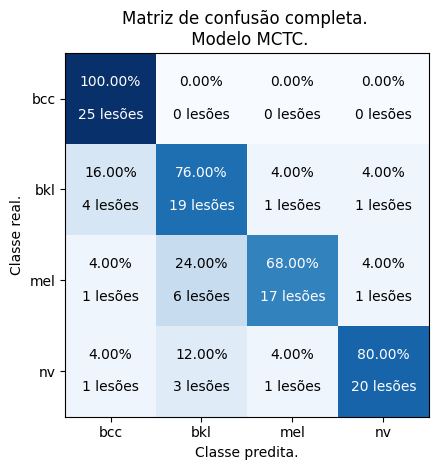

In [ ]:
import itertools

#Plotando a matriz de confusão
class_names=['bcc','bkl','mel','nv']
cm=confusion_matrix(y_true, class_pred, normalize='true')
title='Matriz de confusão completa. \n Modelo MCTC.'
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks, class_names)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, format(cm[i, j]*100, '.2f')+'%\n\n'+format(cm[i, j]*25, '.0f') + ' lesões',
  horizontalalignment="center",
  verticalalignment="center",
  color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Classe real.')
plt.xlabel('Classe predita.')
plt.tight_layout()

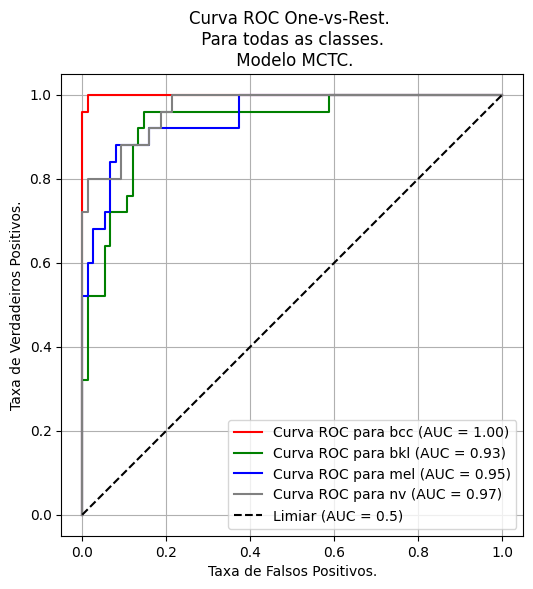

In [ ]:
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))

class_pred_bin = LabelBinarizer().fit(y_true)
y_true_bin = class_pred_bin.transform(y_true)

colors = cycle(["red","green","blue","gray"])
classes = class_pred_bin.classes_
n_classes = len(np.unique(classes))
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(y_true_bin[:, class_id],
                                     y_predict[:, class_id],
                                     name=f"Curva ROC para {classes[class_id]}",
                                     color=color,
                                     ax=ax
                                     )

plt.plot([0, 1], [0, 1], "k--", label="Limiar (AUC = 0.5)")
plt.axis("square")
plt.xlabel("Taxa de Falsos Positivos.")
plt.ylabel("Taxa de Verdadeiros Positivos.")
plt.title("Curva ROC One-vs-Rest. \n Para todas as classes. \n Modelo MCTC.")
plt.legend()
plt.grid()
plt.show()

##*Teste - 1600 imagens*

Teste com um total de 1600 imagens, sendo, 1200 para treinamento, 320 para validação e 80 para teste. As transformações realizadas nas imagens pertecentes à base de treinamento são:

```
horizontal_flip=True,
vertical_flip=False,
height_shift_range=0.1,
width_shift_range=0.1,
rotation_range=30,
zoom_range=0.125,
```

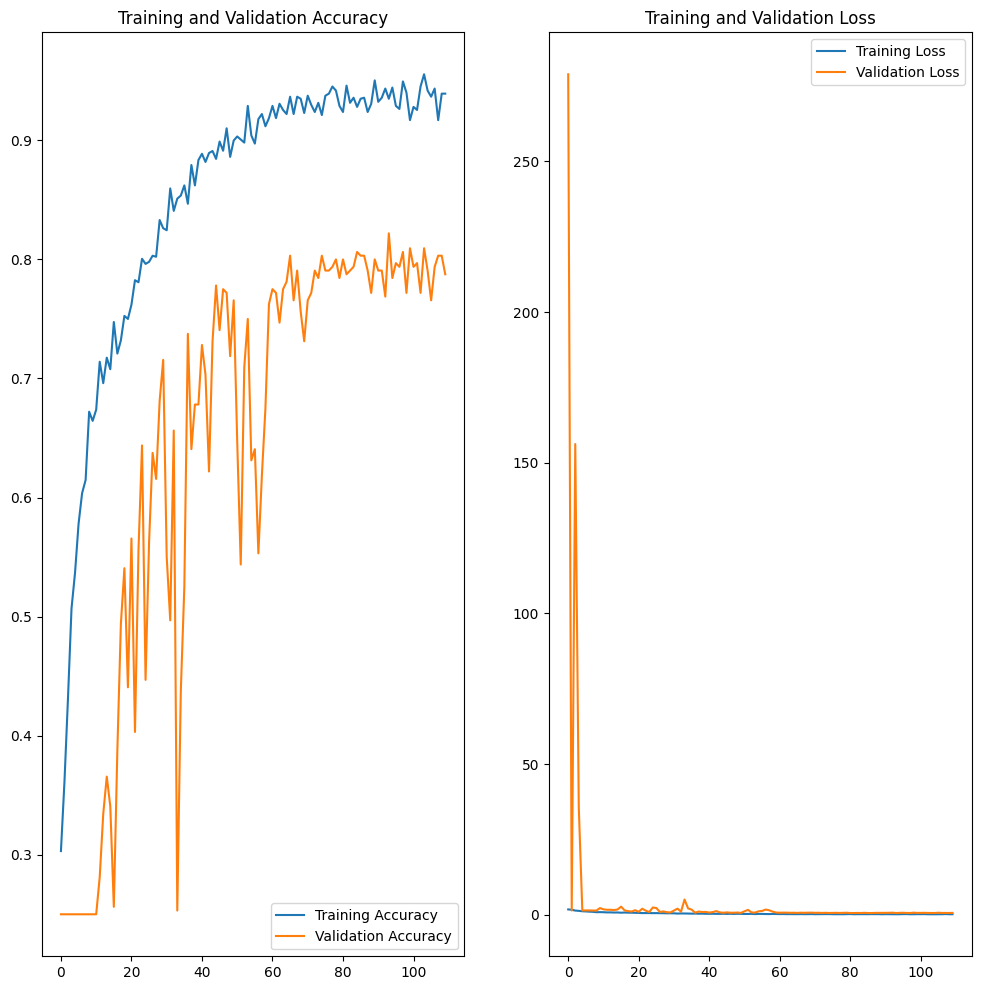

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(110)

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from keras.utils import load_img, img_to_array

image_path_test_bcc = list(data_dir_test.glob('bcc/*.jpg'))
df_bcc = pd.DataFrame(image_path_test_bcc, columns=['images'])
df_bcc['classes']='bcc'

image_path_test_bkl = list(data_dir_test.glob('bkl/*.jpg'))
df_bkl = pd.DataFrame(image_path_test_bkl, columns=['images'])
df_bkl['classes']='bkl'

image_path_test_mel = list(data_dir_test.glob('mel/*.jpg'))
df_mel = pd.DataFrame(image_path_test_mel, columns=['images'])
df_mel['classes']='mel'

image_path_test_nv = list(data_dir_test.glob('nv/*.jpg'))
df_nv = pd.DataFrame(image_path_test_nv, columns=['images'])
df_nv['classes']='nv'

df_teste = pd.concat([df_bcc, df_bkl, df_mel, df_nv], ignore_index=True)

imgs = []
for image_name in df_teste['images'].values:
   img = load_img(image_name, target_size = (img_height, img_width), color_mode = 'rgb')
   img_array = img_to_array(img)
   img_array = img_array/255.
   imgs.append(img_array)
imgs = np.array(imgs)

In [ ]:
#Carregando o melhor conjunto de pesos
model_test_5 = tf.keras.models.load_model(path_check_point_model_5)

#Realizando a predição no modelo treinado
y_predict = model_test_5.predict(imgs, verbose=1)
class_pred = []

for pred in y_predict:
  class_number = np.argmax(pred)
  if class_number == 0:
    class_pred.append('bcc')
  elif class_number == 1:
    class_pred.append('bkl')
  elif class_number == 2:
    class_pred.append('mel')
  else:
    class_pred.append('nv')

y_true = df_teste['classes'].values

3/3 [==============================] - 2s 150ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

erro, acurácia = model_test_5.evaluate(test_generator, batch_size = batch_size)
print(classification_report(y_true, class_pred, target_names = ['bcc','bkl','mel','nv']))
print('\n')
print('Erro:', format(erro, '.2f'), '\nAcurácia:', format(acurácia, '.2f'))

3/3 [==============================] - 3s 293ms/step - loss: 0.6839 - accuracy: 0.7500
              precision    recall  f1-score   support

         bcc       0.86      0.90      0.88        20
         bkl       0.68      0.65      0.67        20
         mel       0.64      0.80      0.71        20
          nv       0.87      0.65      0.74        20

    accuracy                           0.75        80
   macro avg       0.76      0.75      0.75        80
weighted avg       0.76      0.75      0.75        80



Erro: 0.68 
Acurácia: 0.75


In [ ]:
pred_aux = class_pred.copy()

for i in list(range(0, 20, 1)):
  if pred_aux[i] != 'bcc':
    pred_aux[i] = 'non_bcc'

for i in list(range(20, 40, 1)):
  if pred_aux[i] != 'bkl':
    pred_aux[i] = 'non_bkl'

for i in list(range(40, 60, 1)):
  if pred_aux[i] != 'mel':
    pred_aux[i] = 'non_mel'

for i in list(range(60, 80, 1)):
  if pred_aux[i] != 'nv':
    pred_aux[i] = 'non_nv'

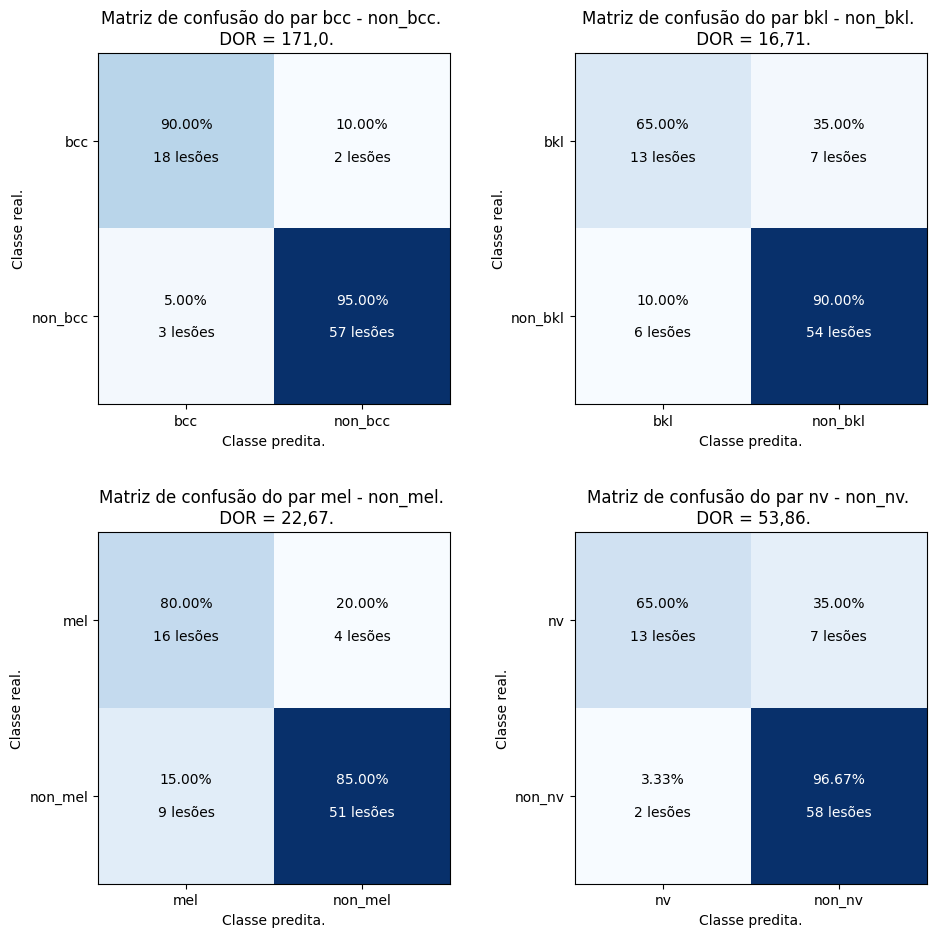

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

classes_pair = [['bcc','non_bcc'], ['bkl','non_bkl'], ['mel','non_mel'], ['nv', 'non_nv']]
cm = []
dor = []

for i in range(len(classes_pair)):
  aux_true = []
  aux_pred = []

  aux_true = [x if x == classes_pair[i][0] else classes_pair[i][1] for x in y_true]
  aux_pred = [y if y == classes_pair[i][0] else classes_pair[i][1] for y in class_pred]

  cm_aux = confusion_matrix(aux_true, aux_pred, normalize=None , labels=classes_pair[i])
  cm.append(cm_aux)

  if cm_aux[0,1] == 0 or cm_aux[1,0] == 0 or cm_aux[0,1] == 0:
    dor.append('Não se define')
  else:
    dor_aux = round((cm_aux[0,0]/cm_aux[0,1])/(cm_aux[1,0]/cm_aux[1,1]), 2)
    dor.append(dor_aux)

dor = [str(i) for i in dor]
dor = [i.replace('.',',') for i in dor]


plt.figure(figsize = (10, 10))

for i in range(len(classes_pair)):
  ax=plt.subplot(2, 2, i+1)
  title=f'Matriz de confusão do par {classes_pair[i][0]} - {classes_pair[i][1]}. \n DOR = {dor[i]}.'
  plt.imshow(cm[i], interpolation='nearest', cmap=plt.cm.Blues)
  plt.title(title)
  tick_marks = np.arange(len(classes_pair[i]))
  plt.xticks(tick_marks, classes_pair[i], rotation=0)
  plt.yticks(tick_marks, classes_pair[i])
  thresh = cm[i].max() / 2.
  for k, p in itertools.product(range(cm[i].shape[0]), range(cm[i].shape[1])):
    if k == 0:
        plt.text(p, k, format(cm[i][k, p]*100/20, '.2f')+'%\n\n'+format(cm[i][k, p], '.0f') + ' lesões',
        horizontalalignment="center",
        verticalalignment="center",
        color="white" if cm[i][k, p] > thresh else "black",
        )
    else:
        plt.text(p, k, format(cm[i][k, p]*100/60, '.2f')+'%\n\n'+format(cm[i][k, p], '.0f') + ' lesões',
        horizontalalignment="center",
        verticalalignment="center",
        color="white" if cm[i][k, p] > thresh else "black",
        )

    plt.ylabel('Classe real.')
    plt.xlabel('Classe predita.')
    plt.tight_layout(pad = 3)

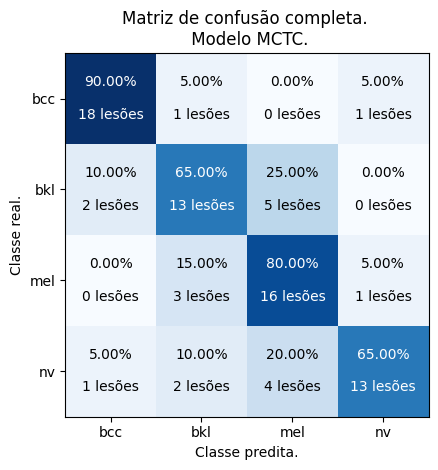

In [ ]:
import itertools

#Plotando a matriz de confusão
class_names=['bcc','bkl','mel','nv']
cm=confusion_matrix(y_true, class_pred, normalize='true')
title='Matriz de confusão completa. \n Modelo MCTC.'
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks, class_names)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, format(cm[i, j]*100, '.2f')+'%\n\n'+format(cm[i, j]*20, '.0f') + ' lesões',
  horizontalalignment="center",
  verticalalignment="center",
  color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Classe real.')
plt.xlabel('Classe predita.')
plt.tight_layout()

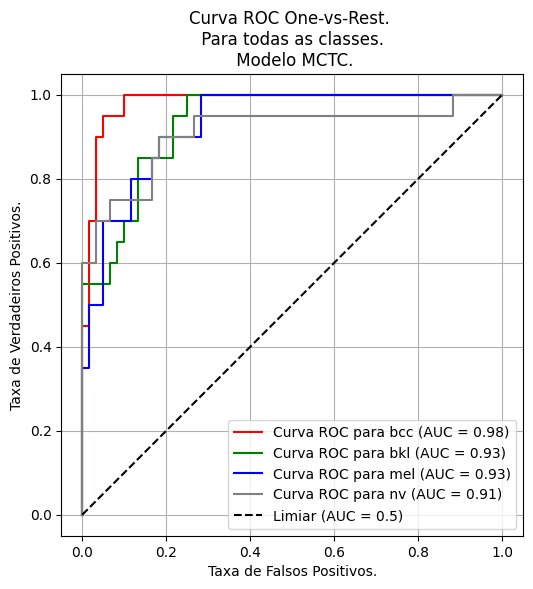

In [ ]:
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))

class_pred_bin = LabelBinarizer().fit(y_true)
y_true_bin = class_pred_bin.transform(y_true)

colors = cycle(["red","green","blue","gray"])
classes = class_pred_bin.classes_
n_classes = len(np.unique(classes))
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(y_true_bin[:, class_id],
                                     y_predict[:, class_id],
                                     name=f"Curva ROC para {classes[class_id]}",
                                     color=color,
                                     ax=ax
                                     )

plt.plot([0, 1], [0, 1], "k--", label="Limiar (AUC = 0.5)")
plt.axis("square")
plt.xlabel("Taxa de Falsos Positivos.")
plt.ylabel("Taxa de Verdadeiros Positivos.")
plt.title("Curva ROC One-vs-Rest. \n Para todas as classes. \n Modelo MCTC.")
plt.legend()
plt.grid()
plt.show()

##*Teste - 1200 imagens*

Teste com um total de 1200 imagens, sendo, 900 para treinamento, 240 para validação e 60 para teste. As transformações realizadas nas imagens pertecentes à base de treinamento são:

```
horizontal_flip=True,
vertical_flip=False,
height_shift_range=0.1,
width_shift_range=0.1,
rotation_range=30,
zoom_range=0.125,
```

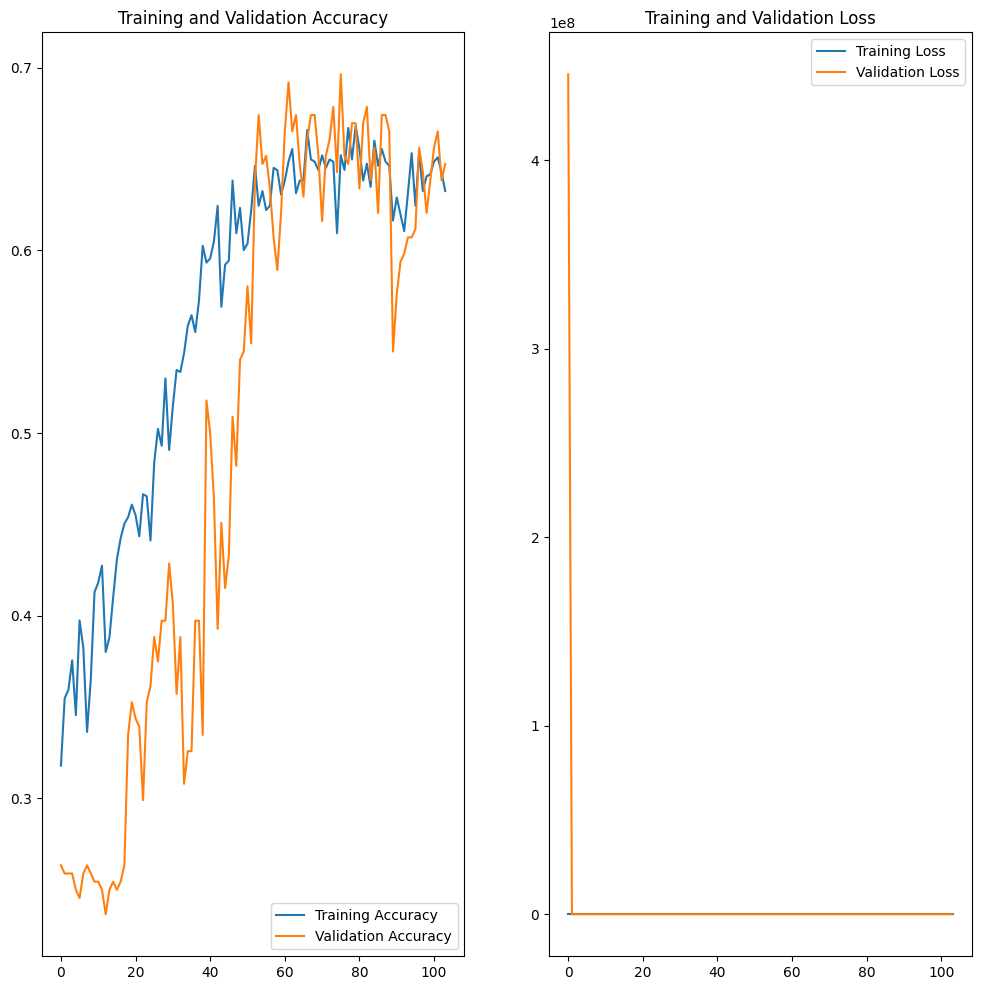

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(104)

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from keras.utils import load_img, img_to_array

image_path_test_bcc = list(data_dir_test.glob('bcc/*.jpg'))
df_bcc = pd.DataFrame(image_path_test_bcc, columns=['images'])
df_bcc['classes']='bcc'

image_path_test_bkl = list(data_dir_test.glob('bkl/*.jpg'))
df_bkl = pd.DataFrame(image_path_test_bkl, columns=['images'])
df_bkl['classes']='bkl'

image_path_test_mel = list(data_dir_test.glob('mel/*.jpg'))
df_mel = pd.DataFrame(image_path_test_mel, columns=['images'])
df_mel['classes']='mel'

image_path_test_nv = list(data_dir_test.glob('nv/*.jpg'))
df_nv = pd.DataFrame(image_path_test_nv, columns=['images'])
df_nv['classes']='nv'

df_teste = pd.concat([df_bcc, df_bkl, df_mel, df_nv], ignore_index=True)

imgs = []
for image_name in df_teste['images'].values:
   img = load_img(image_name, target_size = (img_height, img_width), color_mode = 'rgb')
   img_array = img_to_array(img)
   img_array = img_array/255.
   imgs.append(img_array)
imgs = np.array(imgs)

In [ ]:
#Carregando o melhor conjunto de pesos
model_test_5 = tf.keras.models.load_model(path_check_point_model_5)

#Realizando a predição no modelo treinado
y_predict = model_test_5.predict(imgs, verbose=1)
class_pred = []

for pred in y_predict:
  class_number = np.argmax(pred)
  if class_number == 0:
    class_pred.append('bcc')
  elif class_number == 1:
    class_pred.append('bkl')
  elif class_number == 2:
    class_pred.append('mel')
  else:
    class_pred.append('nv')

y_true = df_teste['classes'].values

2/2 [==============================] - 5s 3s/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

erro, acurácia = model_test_5.evaluate(test_generator, batch_size = batch_size)
print(classification_report(y_true, class_pred, target_names = ['bcc','bkl','mel','nv']))
print('\n')
print('Erro:', format(erro, '.2f'), '\nAcurácia:', format(acurácia, '.2f'))

2/2 [==============================] - 3s 487ms/step - loss: 0.8728 - accuracy: 0.5667
              precision    recall  f1-score   support

         bcc       0.80      0.53      0.64        15
         bkl       0.38      0.33      0.36        15
         mel       0.44      0.73      0.55        15
          nv       0.83      0.67      0.74        15

    accuracy                           0.57        60
   macro avg       0.61      0.57      0.57        60
weighted avg       0.61      0.57      0.57        60



Erro: 0.87 
Acurácia: 0.57


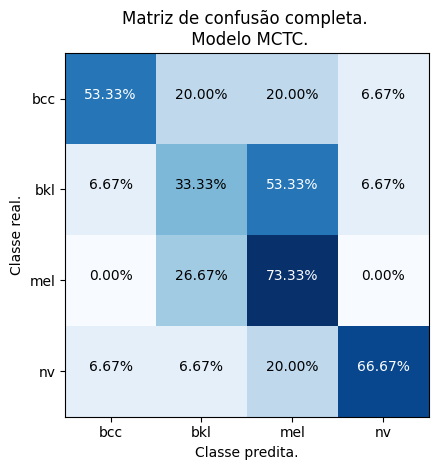

In [ ]:
#Plotando a matriz de confusão
class_names=['bcc','bkl','mel','nv']
cm=confusion_matrix(y_true, class_pred, normalize='true')
title='Matriz de confusão completa. \n Modelo MCTC.'
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks, class_names)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, format(cm[i, j]*100, '.2f')+'%',
  horizontalalignment="center",
  color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Classe real.')
plt.xlabel('Classe predita.')
plt.tight_layout()

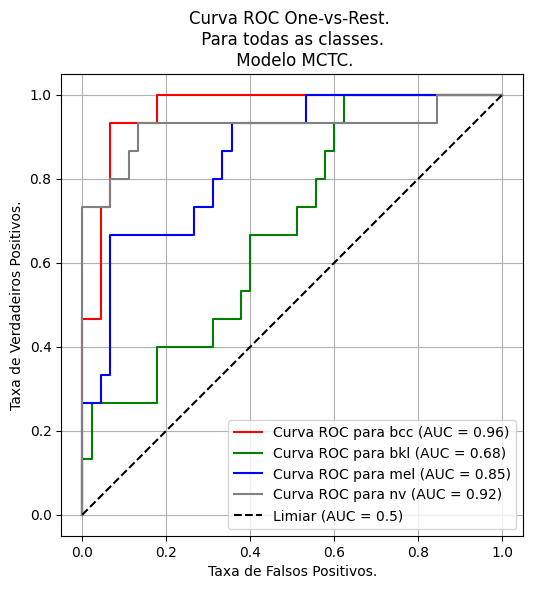

In [ ]:
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))

class_pred_bin = LabelBinarizer().fit(y_true)
y_true_bin = class_pred_bin.transform(y_true)

colors = cycle(["red","green","blue","gray"])
classes = class_pred_bin.classes_
n_classes = len(np.unique(classes))
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(y_true_bin[:, class_id],
                                     y_predict[:, class_id],
                                     name=f"Curva ROC para {classes[class_id]}",
                                     color=color,
                                     ax=ax
                                     )

plt.plot([0, 1], [0, 1], "k--", label="Limiar (AUC = 0.5)")
plt.axis("square")
plt.xlabel("Taxa de Falsos Positivos.")
plt.ylabel("Taxa de Verdadeiros Positivos.")
plt.title("Curva ROC One-vs-Rest. \n Para todas as classes. \n Modelo MCTC.")
plt.legend()
plt.grid()
plt.show()

##*Teste - 800 imagens*

Teste com um total de 800 imagens, sendo, 600 para treinamento, 160 para validação e 40 para teste. As transformações realizadas nas imagens pertecentes à base de treinamento são:

```
horizontal_flip=True,
vertical_flip=False,
height_shift_range=0.1,
width_shift_range=0.1,
rotation_range=30,
zoom_range=0.125,
```

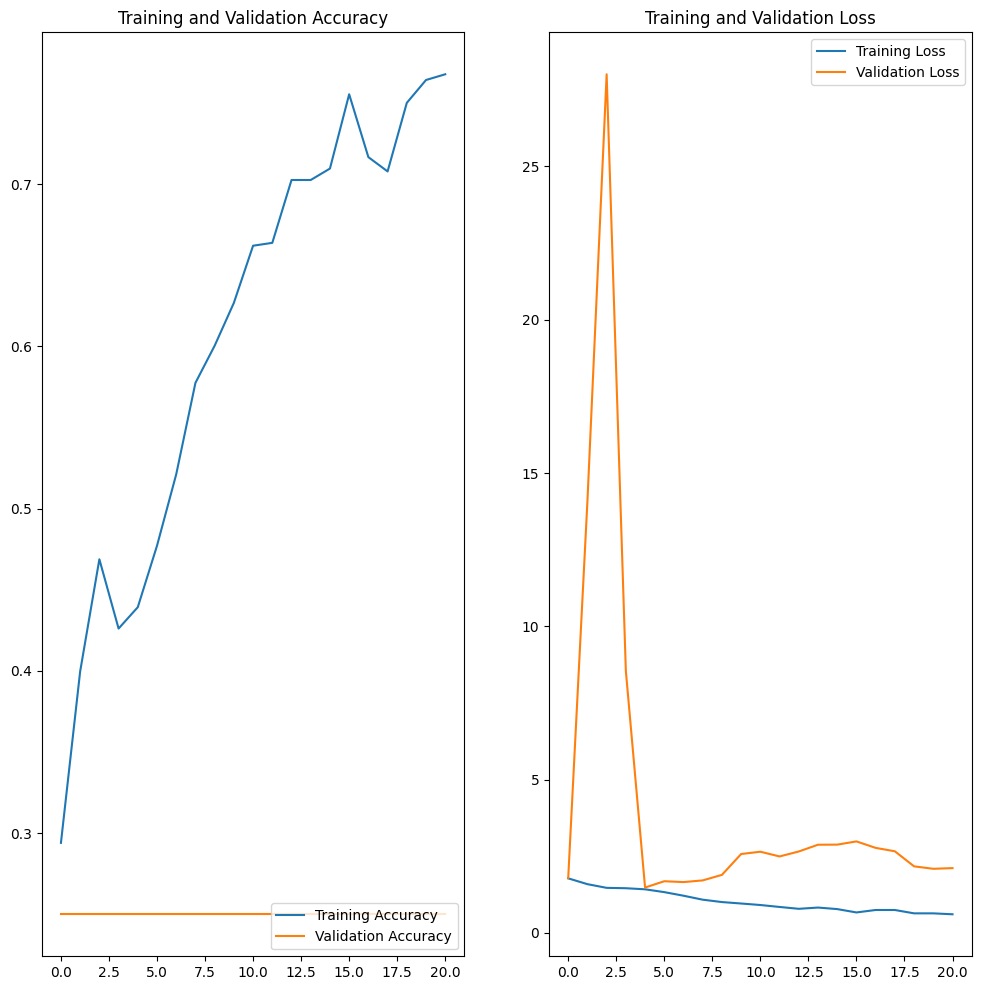

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(21)

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from keras.utils import load_img, img_to_array

image_path_test_bcc = list(data_dir_test.glob('bcc/*.jpg'))
df_bcc = pd.DataFrame(image_path_test_bcc, columns=['images'])
df_bcc['classes']='bcc'

image_path_test_bkl = list(data_dir_test.glob('bkl/*.jpg'))
df_bkl = pd.DataFrame(image_path_test_bkl, columns=['images'])
df_bkl['classes']='bkl'

image_path_test_mel = list(data_dir_test.glob('mel/*.jpg'))
df_mel = pd.DataFrame(image_path_test_mel, columns=['images'])
df_mel['classes']='mel'

image_path_test_nv = list(data_dir_test.glob('nv/*.jpg'))
df_nv = pd.DataFrame(image_path_test_nv, columns=['images'])
df_nv['classes']='nv'

df_teste = pd.concat([df_bcc, df_bkl, df_mel, df_nv], ignore_index=True)

imgs = []
for image_name in df_teste['images'].values:
   img = load_img(image_name, target_size = (img_height, img_width), color_mode = 'rgb')
   img_array = img_to_array(img)
   img_array = img_array/255.
   imgs.append(img_array)
imgs = np.array(imgs)

In [ ]:
#Carregando o melhor conjunto de pesos
model_test_5 = tf.keras.models.load_model(path_check_point_model_5)

#Realizando a predição no modelo treinado
y_predict = model_test_5.predict(imgs, verbose=1)
class_pred = []

for pred in y_predict:
  class_number = np.argmax(pred)
  if class_number == 0:
    class_pred.append('bcc')
  elif class_number == 1:
    class_pred.append('bkl')
  elif class_number == 2:
    class_pred.append('mel')
  else:
    class_pred.append('nv')

y_true = df_teste['classes'].values

2/2 [==============================] - 3s 2s/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

erro, acurácia = model_test_5.evaluate(test_generator, batch_size = batch_size)
print(classification_report(y_true, class_pred, target_names = ['bcc','bkl','mel','nv']))
print('\n')
print('Erro:', format(erro, '.2f'), '\nAcurácia:', format(acurácia, '.2f'))

2/2 [==============================] - 3s 67ms/step - loss: 1.4751 - accuracy: 0.2500
              precision    recall  f1-score   support

         bcc       0.25      1.00      0.40        10
         bkl       0.00      0.00      0.00        10
         mel       0.00      0.00      0.00        10
          nv       0.00      0.00      0.00        10

    accuracy                           0.25        40
   macro avg       0.06      0.25      0.10        40
weighted avg       0.06      0.25      0.10        40



Erro: 1.48 
Acurácia: 0.25


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


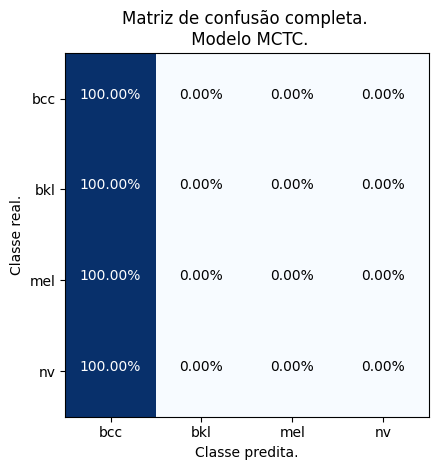

In [ ]:
#Plotando a matriz de confusão
class_names=['bcc','bkl','mel','nv']
cm=confusion_matrix(y_true, class_pred, normalize='true')
title='Matriz de confusão completa. \n Modelo MCTC.'
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks, class_names)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, format(cm[i, j]*100, '.2f')+'%',
  horizontalalignment="center",
  color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Classe real.')
plt.xlabel('Classe predita.')
plt.tight_layout()

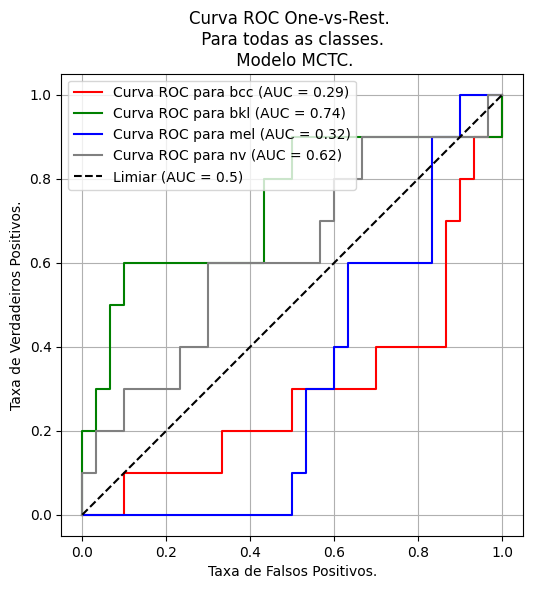

In [ ]:
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))

class_pred_bin = LabelBinarizer().fit(y_true)
y_true_bin = class_pred_bin.transform(y_true)

colors = cycle(["red","green","blue","gray"])
classes = class_pred_bin.classes_
n_classes = len(np.unique(classes))
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(y_true_bin[:, class_id],
                                     y_predict[:, class_id],
                                     name=f"Curva ROC para {classes[class_id]}",
                                     color=color,
                                     ax=ax
                                     )

plt.plot([0, 1], [0, 1], "k--", label="Limiar (AUC = 0.5)")
plt.axis("square")
plt.xlabel("Taxa de Falsos Positivos.")
plt.ylabel("Taxa de Verdadeiros Positivos.")
plt.title("Curva ROC One-vs-Rest. \n Para todas as classes. \n Modelo MCTC.")
plt.legend()
plt.grid()
plt.show()

##*Teste - 400 imagens*

Teste com um total de 400 imagens, sendo, 300 para treinamento, 80 para validação e 20 para teste. As transformações realizadas nas imagens pertecentes à base de treinamento são:

```
horizontal_flip=True,
vertical_flip=False,
height_shift_range=0.1,
width_shift_range=0.1,
rotation_range=30,
zoom_range=0.125,
```

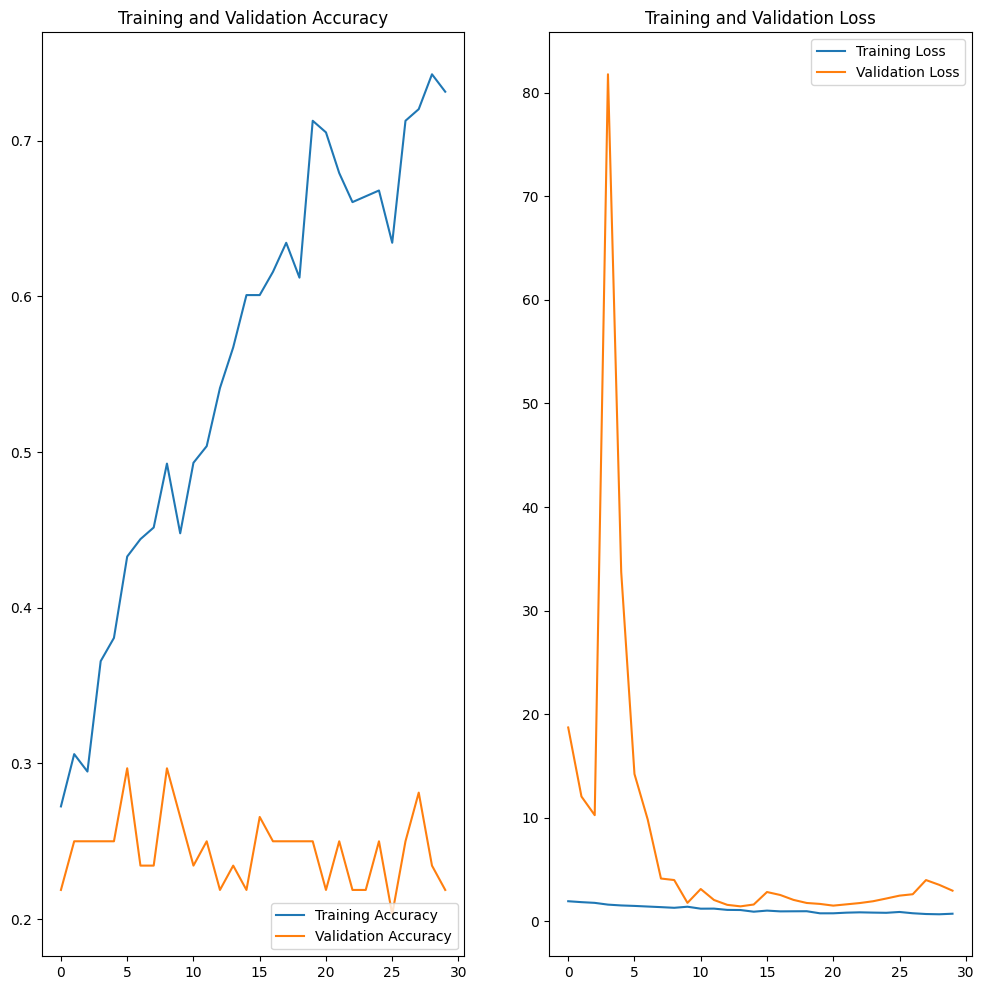

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from keras.utils import load_img, img_to_array

image_path_test_bcc = list(data_dir_test.glob('bcc/*.jpg'))
df_bcc = pd.DataFrame(image_path_test_bcc, columns=['images'])
df_bcc['classes']='bcc'

image_path_test_bkl = list(data_dir_test.glob('bkl/*.jpg'))
df_bkl = pd.DataFrame(image_path_test_bkl, columns=['images'])
df_bkl['classes']='bkl'

image_path_test_mel = list(data_dir_test.glob('mel/*.jpg'))
df_mel = pd.DataFrame(image_path_test_mel, columns=['images'])
df_mel['classes']='mel'

image_path_test_nv = list(data_dir_test.glob('nv/*.jpg'))
df_nv = pd.DataFrame(image_path_test_nv, columns=['images'])
df_nv['classes']='nv'

df_teste = pd.concat([df_bcc, df_bkl, df_mel, df_nv], ignore_index=True)

imgs = []
for image_name in df_teste['images'].values:
   img = load_img(image_name, target_size = (img_height, img_width), color_mode = 'rgb')
   img_array = img_to_array(img)
   img_array = img_array/255.
   imgs.append(img_array)
imgs = np.array(imgs)

In [ ]:
#Carregando o melhor conjunto de pesos
model_test_5 = tf.keras.models.load_model(path_check_point_model_5)

#Realizando a predição no modelo treinado
y_predict = model_test_5.predict(imgs, verbose=1)
class_pred = []

for pred in y_predict:
  class_number = np.argmax(pred)
  if class_number == 0:
    class_pred.append('bcc')
  elif class_number == 1:
    class_pred.append('bkl')
  elif class_number == 2:
    class_pred.append('mel')
  else:
    class_pred.append('nv')

y_true = df_teste['classes'].values

1/1 [==============================] - 4s 4s/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

erro, acurácia = model_test_5.evaluate(test_generator, batch_size = batch_size)
print(classification_report(y_true, class_pred, target_names = ['bcc','bkl','mel','nv']))
print('\n')
print('Erro:', format(erro, '.2f'), '\nAcurácia:', format(acurácia, '.2f'))

1/1 [==============================] - 2s 2s/step - loss: 1.4684 - accuracy: 0.3000
              precision    recall  f1-score   support

         bcc       0.67      0.40      0.50         5
         bkl       0.00      0.00      0.00         5
         mel       0.00      0.00      0.00         5
          nv       0.24      0.80      0.36         5

    accuracy                           0.30        20
   macro avg       0.23      0.30      0.22        20
weighted avg       0.23      0.30      0.22        20



Erro: 1.47 
Acurácia: 0.30


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


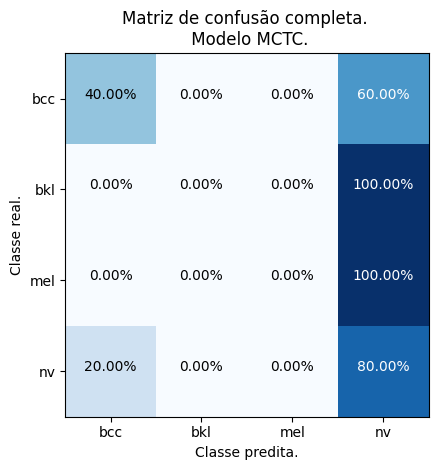

In [ ]:
#Plotando a matriz de confusão
class_names=['bcc','bkl','mel','nv']
cm=confusion_matrix(y_true, class_pred, normalize='true')
title='Matriz de confusão completa. \n Modelo MCTC.'
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks, class_names)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, format(cm[i, j]*100, '.2f')+'%',
  horizontalalignment="center",
  color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Classe real.')
plt.xlabel('Classe predita.')
plt.tight_layout()

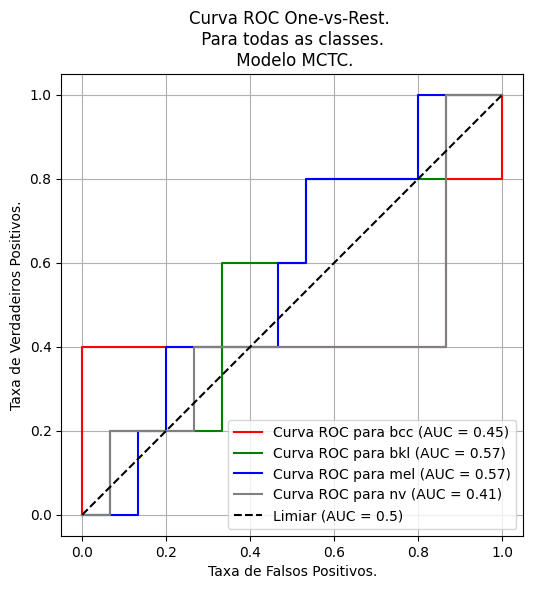

In [ ]:
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))

class_pred_bin = LabelBinarizer().fit(y_true)
y_true_bin = class_pred_bin.transform(y_true)

colors = cycle(["red","green","blue","gray"])
classes = class_pred_bin.classes_
n_classes = len(np.unique(classes))
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(y_true_bin[:, class_id],
                                     y_predict[:, class_id],
                                     name=f"Curva ROC para {classes[class_id]}",
                                     color=color,
                                     ax=ax
                                     )

plt.plot([0, 1], [0, 1], "k--", label="Limiar (AUC = 0.5)")
plt.axis("square")
plt.xlabel("Taxa de Falsos Positivos.")
plt.ylabel("Taxa de Verdadeiros Positivos.")
plt.title("Curva ROC One-vs-Rest. \n Para todas as classes. \n Modelo MCTC.")
plt.legend()
plt.grid()
plt.show()